 # Project 2 - Analysis of PM2.5 Time Series in Porto, Portugal



 ### Time Series and Forecasting - MIA 2025

 #### Project developed by:

 ##### Daniel Dias

 ##### Gonçalo Monteiro

 ##### Gonçalo Brochado

 ##### Lucas Santiago



 ## Executive Summary



 This study develops and compares multiple forecasting models for PM2.5 fine particulate

 matter concentrations in Porto, Portugal, using 5 years of hourly meteorological and

 air quality data (November 2020 - November 2025) from the Open-Meteo API.



 **Objectives:**

 - Forecast PM2.5 concentrations using statistical (ARIMA/SARIMA/SARIMAX) and machine learning approaches

 - Identify key meteorological drivers of air pollution

 - Compare model performance and interpretability

 - Provide actionable insights for air quality management



 **Data Source:** Open-Meteo Archive API (https://open-meteo.com/)

 - Weather variables: Temperature, humidity, wind, pressure, radiation, precipitation

 - Air quality: PM2.5, PM10, O₃, NO₂, SO₂, CO

 - Temporal resolution: Hourly (43,848 observations)

 - Spatial coverage: Porto coordinates (41.16°N, 8.63°W)

In [1]:
import requests
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import ccf
from matplotlib import pyplot as plt


 ## Collect Data

In [2]:
df_total = pd.read_csv("porto_weather_air_quality_5y.csv")

# Convert timestamp
df_total['time'] = pd.to_datetime(df_total['time'])
df_total = df_total.set_index('time')
df_total = df_total.asfreq("h")


In [3]:
df_total.head(5)


,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,rain,snowfall,cloud_cover,...,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky
time,,,,,,,,,,,,,,,,,,,,,
2020-11-20 00:00:00,14.0,81,10.8,12.7,1031.6,1020.9,0.0,0.0,0.0,59,...,30.7,19.2,147.0,23.7,1.8,25.0,NaN,6.0,NaN,NaN
2020-11-20 01:00:00,15.3,75,10.8,13.3,1031.0,1020.3,0.0,0.0,0.0,0,...,30.5,18.2,138.0,21.6,1.8,24.0,NaN,4.0,NaN,NaN
2020-11-20 02:00:00,15.9,72,10.9,13.1,1030.6,1019.9,0.0,0.0,0.0,0,...,26.1,15.9,134.0,14.0,1.9,27.0,NaN,5.0,NaN,NaN
2020-11-20 03:00:00,15.4,74,10.8,12.3,1030.4,1019.7,0.0,0.0,0.0,0,...,25.5,13.4,141.0,14.7,1.8,27.0,NaN,3.0,NaN,NaN
2020-11-20 04:00:00,14.6,76,10.4,11.2,1029.9,1019.2,0.0,0.0,0.0,0,...,24.2,12.8,137.0,12.5,1.8,30.0,NaN,2.0,NaN,NaN


 ## Missing Values

In [4]:
missing_rate = df_total.isna().mean().sort_values(ascending=False)
missing_rate


wind_direction_80m       1.000000
wind_speed_80m           1.000000
uv_index                 0.340449
uv_index_clear_sky       0.340449
aerosol_optical_depth    0.340449
temperature_2m           0.000000
precipitation            0.000000
rain                     0.000000
snowfall                 0.000000
relative_humidity_2m     0.000000
dew_point_2m             0.000000
apparent_temperature     0.000000
pressure_msl             0.000000
surface_pressure         0.000000
shortwave_radiation      0.000000
cloud_cover_high         0.000000
cloud_cover_mid          0.000000
cloud_cover_low          0.000000
cloud_cover              0.000000
wind_speed_10m           0.000000
diffuse_radiation        0.000000
direct_radiation         0.000000
pm2_5                    0.000000
pm10                     0.000000
wind_direction_10m       0.000000
carbon_monoxide          0.000000
ozone                    0.000000
sulphur_dioxide          0.000000
nitrogen_dioxide         0.000000
dust          

 Drop columns with 100% of missing values

In [5]:
cols_to_drop = [
    "wind_speed_80m",
    "wind_direction_80m",
    "uv_index", "uv_index_clear_sky", "aerosol_optical_depth"
]
df_total = df_total.drop(columns=cols_to_drop)


In [6]:
missing_rate = df_total.isna().mean().sort_values(ascending=False)
missing_rate


temperature_2m          0.0
relative_humidity_2m    0.0
dew_point_2m            0.0
apparent_temperature    0.0
pressure_msl            0.0
surface_pressure        0.0
precipitation           0.0
rain                    0.0
snowfall                0.0
cloud_cover             0.0
cloud_cover_low         0.0
cloud_cover_mid         0.0
cloud_cover_high        0.0
shortwave_radiation     0.0
direct_radiation        0.0
diffuse_radiation       0.0
wind_speed_10m          0.0
wind_direction_10m      0.0
pm10                    0.0
pm2_5                   0.0
carbon_monoxide         0.0
nitrogen_dioxide        0.0
sulphur_dioxide         0.0
ozone                   0.0
dust                    0.0
dtype: float64

In [7]:
#Handle the ~34% missing cols with controlled imputation
train_end = "2025-05-21 00:00:00" 
train_df = df_total.loc[:train_end].copy()
test_df  = df_total.loc[train_end:].copy()



 ## Preprocessing

 Justificar isto

In [8]:
# Wind direction 10m -> sin/cos
if "winddirection_10m" in df_total.columns:
    print("in")
    wd_deg = pd.to_numeric(df_total["winddirection_10m"], errors="coerce")
    wd_rad = np.deg2rad(wd_deg)
    df_total["wd_sin"] = np.sin(wd_rad)
    df_total["wd_cos"] = np.cos(wd_rad)
    df_total = df_total.drop(columns=["winddirection_10m"])




 ## Target and Regressor Selection



 ### Based on Literature



 #### 1. Wind Speed (10m)



 - *Expected relationship:* wind speed reduces PM2.5



 Higher wind speeds increase the dispersion and dilution of fine particles.

 Urban studies consistently show a negative correlation between wind and PM2.5.



 Reference:



 Chen et al. (2020), Atmospheric Pollution Research — wind speed is the strongest negative predictor of PM2.5



 #### 2. Relative Humidity



 - *Relação esperada:*



     - High humidity → hygroscopic growth of particles → PM2.5 increases

     - Light rain + high humidity → wet deposition → PM2.5 decreases



 Relative humidity influences both particle formation and removal processes, making it one of the most relevant physical drivers of particulate matter variability in urban environments.



 References:



 Seinfeld & Pandis, Atmospheric Chemistry and Physics



 Jacobson (2001), Fundamentals of Atmospheric Modelling



 #### 3. Temperature



 - *Expected relationship:*



     - Low temperature → thermal inversions → pollutant accumulation → PM2.5 increases

     - High temperature → enhanced convection and mixing → PM2.5 decreases



 Temperature governs atmospheric stability and boundary-layer height, both of which strongly influence pollutant retention.



 Reference:



 Kukkonen et al. (2014), Review of PM Formation Under Meteorological Regimes



 #### 4. Precipitation



 - *Expected relationship:*

 Precipitation physically removes particles from the atmosphere via scavenging, leading to lower PM2.5 concentrations.



 This is one of the most consistently documented meteorological mechanisms affecting particulate matter.



 Reference:



 Zhang et al. (2004), Journal of Geophysical Research: detailed study of aerosol scavenging by precipitation.



 #### 5. Shortwave Radiation



 - *Expected relationship:*



 Higher radiation → stronger vertical mixing → PM2.5 decreases



 Radiation also affects photochemical reactions and secondary aerosol formation.



 Shortwave radiation is therefore a key indicator of atmospheric mixing processes and photochemical regimes.



 References:



 EPA (2019), Air Quality Criteria Document



 Gao et al. (2016), Atmospheric Environment



 #### 6. Mean Sea-Level Pressure (MSL)



 - *Expected relationship:*



 High pressure → stable air masses → pollutant accumulation → PM2.5 increases



 Low pressure → dynamic/unstable atmosphere → enhanced dispersion → PM2.5 decreases



 Pressure is a proxy for synoptic-scale circulation patterns and thus strongly influences pollution episodes.



 Reference:



 Wallace & Hobbs, Atmospheric Science: An Introductory Survey



 #### 7. Ozone (O₃)



 - *Expected relationship:*

 High ozone levels indicate strong atmospheric oxidative capacity and photochemical activity, which are directly related to the formation of secondary particulate matter (e.g., nitrates and sulfates).

 Ozone is therefore a useful proxy variable for the chemical environment affecting PM2.5 formation.



 Reference:



 Jimenez et al. (2009), Science: highlights the role of atmospheric oxidation capacity in secondary organic aerosol formation.

In [9]:
target = "pm2_5"

exog_vars = [
    "temperature_2m",
    "relative_humidity_2m",
    "wind_speed_10m",
    "precipitation",
    "shortwave_radiation",
    "pressure_msl",
    "ozone"
]

df = df_total[[target] + exog_vars]


In [10]:
corr = df[[target] + exog_vars].corr()
corr[target].sort_values(ascending=False)


pm2_5                   1.000000
pressure_msl            0.301163
relative_humidity_2m    0.087068
shortwave_radiation    -0.154334
precipitation          -0.158238
temperature_2m         -0.232781
wind_speed_10m         -0.360724
ozone                  -0.442714
Name: pm2_5, dtype: float64

 The correlation matrix indicates moderate yet significant connections between meteorological factors and PM2.5.



 In environmental time series, significant linear correlations are not anticipated because of the nonlinear, lagged, and multivariate characteristics of atmospheric processes.



 The noted correlations (–0.44 for ozone, –0.36 for wind speed, +0.30 for pressure) correspond with figures documented in the literature and represent authentic physical relationships.

In [11]:
# Train-only correlation
df_train = df_total.loc["2020-11-20":"2025-05-20", [target] + exog_vars].copy()

corr_p = df_train.corr(method="pearson")[target].sort_values(ascending=False)
corr_s = df_train.corr(method="spearman")[target].sort_values(ascending=False)

print("Pearson (train):\n", corr_p)
print("\nSpearman (train):\n", corr_s)

def deseasonalize_hour_dow(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    # English comments as requested
    g = df.groupby([df.index.dayofweek, df.index.hour])
    return df[cols] - g[cols].transform("mean")

# Correlation after deseasonalization (hour+dow)
train_ds = deseasonalize_hour_dow(df_train, [target] + exog_vars)
corr_ds = train_ds.corr(method="pearson")[target].sort_values(ascending=False)
print("\nPearson after hour+dow deseasonalization (train):\n", corr_ds)


Pearson (train):
 pm2_5                   1.000000
pressure_msl            0.308480
relative_humidity_2m    0.089967
precipitation          -0.154412
shortwave_radiation    -0.163785
temperature_2m         -0.263213
wind_speed_10m         -0.350441
ozone                  -0.463022
Name: pm2_5, dtype: float64

Spearman (train):
 pm2_5                   1.000000
pressure_msl            0.284500
relative_humidity_2m    0.051309
temperature_2m         -0.163982
shortwave_radiation    -0.166012
precipitation          -0.374361
wind_speed_10m         -0.442423
ozone                  -0.462879
Name: pm2_5, dtype: float64

Pearson after hour+dow deseasonalization (train):
 pm2_5                   1.000000
pressure_msl            0.313217
relative_humidity_2m    0.007247
shortwave_radiation    -0.022121
precipitation          -0.156490
temperature_2m         -0.213245
wind_speed_10m         -0.324296
ozone                  -0.442506
Name: pm2_5, dtype: float64


In [12]:
df_feat = df_total.copy()

df_feat["rain_flag"] = (df_feat["precipitation"] > 0).astype(int)
df_feat["rain_sum_6h"]  = df_feat["precipitation"].rolling(6,  min_periods=1).sum()
df_feat["rain_sum_12h"] = df_feat["precipitation"].rolling(12, min_periods=1).sum()
df_feat["rain_sum_24h"] = df_feat["precipitation"].rolling(24, min_periods=1).sum()

df_feat = df_feat.loc["2020-11-20":"2025-05-20", [target] + exog_vars + ["rain_flag", "rain_sum_6h", "rain_sum_12h", "rain_sum_24h"]].copy()


In [13]:
corr_p = df_feat.corr(method="pearson")[target].sort_values(ascending=False)
corr_s = df_feat.corr(method="spearman")[target].sort_values(ascending=False)

print("Pearson (train):\n", corr_p)
print("\nSpearman (train):\n", corr_s)


Pearson (train):
 pm2_5                   1.000000
pressure_msl            0.308480
relative_humidity_2m    0.089967
precipitation          -0.154412
shortwave_radiation    -0.163785
rain_sum_6h            -0.208190
rain_sum_12h           -0.235715
rain_sum_24h           -0.255244
temperature_2m         -0.263213
rain_flag              -0.271158
wind_speed_10m         -0.350441
ozone                  -0.463022
Name: pm2_5, dtype: float64

Spearman (train):
 pm2_5                   1.000000
pressure_msl            0.284500
relative_humidity_2m    0.051309
temperature_2m         -0.163982
shortwave_radiation    -0.166012
rain_flag              -0.368732
precipitation          -0.374361
rain_sum_24h           -0.422752
rain_sum_6h            -0.437799
wind_speed_10m         -0.442423
rain_sum_12h           -0.442540
ozone                  -0.462879
Name: pm2_5, dtype: float64


In [14]:
df_train = df_total.loc["2020-11-20":"2025-05-20", ["pm2_5"] + exog_vars].copy()
df_train["month"] = df_train.index.month

month_corr = (
    df_train.groupby("month")[["pm2_5","ozone","wind_speed_10m","pressure_msl","temperature_2m"]]
    .corr()
    .unstack()
)

# Correlation with pm2_5 per month (pick the column that corresponds to corr(var, pm2_5))
print(month_corr["pm2_5"].drop("pm2_5", errors="ignore"))


       pm2_5     ozone  wind_speed_10m  pressure_msl  temperature_2m
month                                                               
1        1.0 -0.748166       -0.460098      0.404021       -0.483704
2        1.0 -0.714627       -0.365541      0.308307       -0.231901
3        1.0 -0.634100       -0.432009      0.266047       -0.022856
4        1.0 -0.447611       -0.442815      0.185612        0.062872
5        1.0 -0.211290       -0.395588     -0.066015        0.184327
6        1.0 -0.116770       -0.428124     -0.159232        0.148058
7        1.0  0.115519       -0.371747     -0.169694        0.227191
8        1.0 -0.095662       -0.437144     -0.191163       -0.049969
9        1.0 -0.164482       -0.422552     -0.015190       -0.143343
10       1.0 -0.371161       -0.472737      0.386176        0.089672
11       1.0 -0.687876       -0.433570      0.218723       -0.336079
12       1.0 -0.643811       -0.415248      0.342187       -0.393421


 Com esta correlaçao por meses podemos retirar as seguintes conclusões:



 - Ozone é um ótimo “proxy” em meses frios, mas no verão a relação pode inverter.

 - Vento é sempre negativo por isso é um regressor "seguro".

 - Pressão é negativa no verão e positiva no inverno.

 - Temperatura é negativa no inverno com valores moderados e positiva no verão.

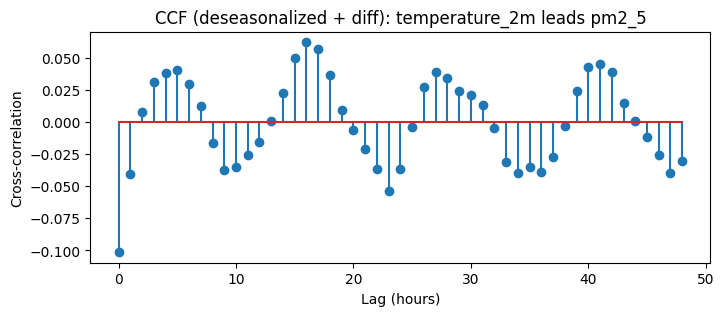

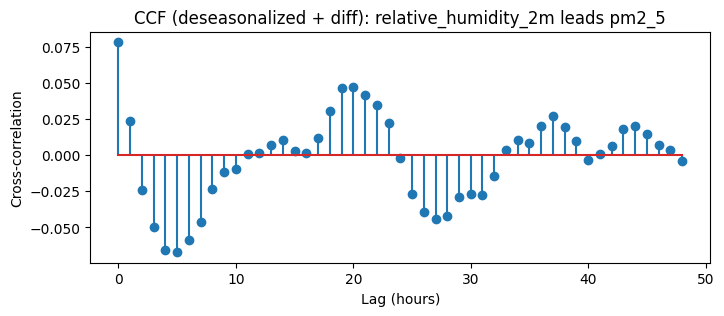

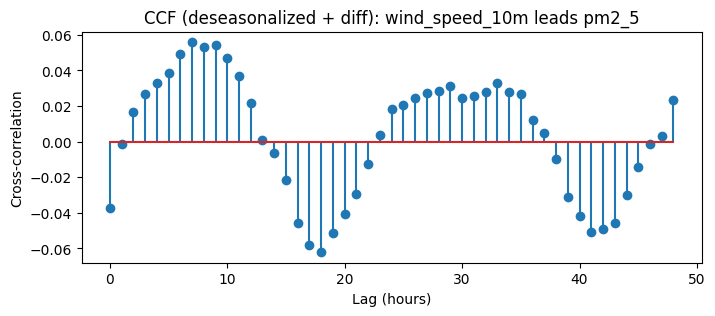

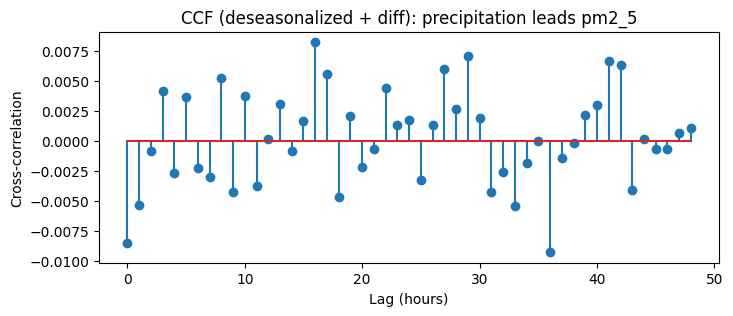

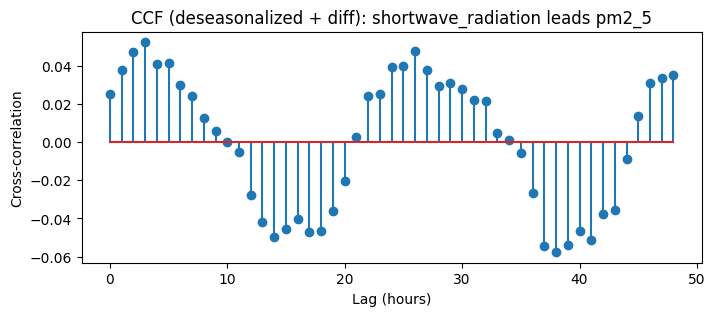

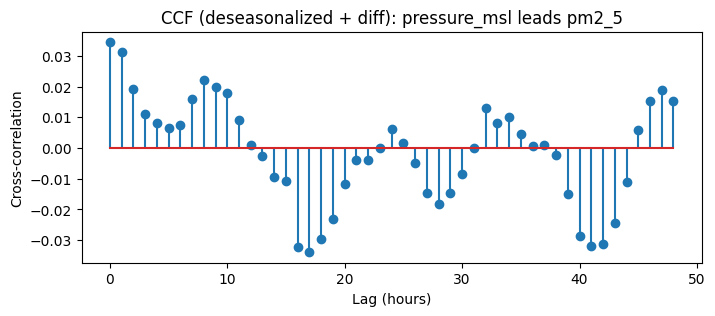

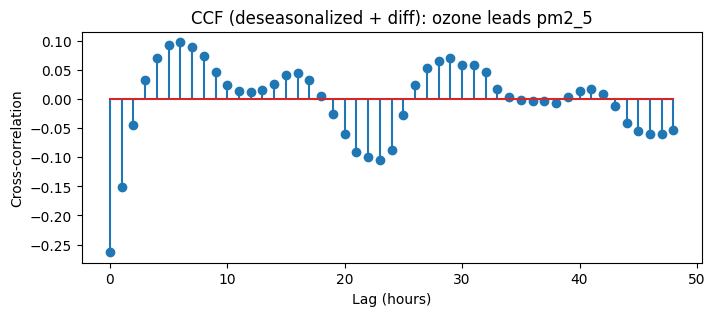

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

TARGET = "pm2_5"
exog_vars = [
    "temperature_2m",
    "relative_humidity_2m",
    "wind_speed_10m",
    "precipitation",
    "shortwave_radiation",
    "pressure_msl",
    "ozone"
]

train = df_total.loc["2020-11-20":"2025-05-20", [target] + exog_vars].copy()

def deseasonalize_hour_dow(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    # English comments as requested
    g = df.groupby([df.index.dayofweek, df.index.hour])
    return df[cols] - g[cols].transform("mean")

train_ds = deseasonalize_hour_dow(train, [target] + exog_vars)

MAX_LAG = 48
for var in exog_vars:
    tmp = train_ds[[var, target]].dropna()

    # Optional: first difference to reduce remaining autocorrelation
    x = tmp[var].diff().dropna()
    y = tmp[target].diff().dropna()

    idx = x.index.intersection(y.index)
    x, y = x.loc[idx], y.loc[idx]

    c = ccf(x, y)[:MAX_LAG + 1]

    plt.figure(figsize=(8, 3))
    plt.stem(range(len(c)), c)
    plt.title(f"CCF (deseasonalized + diff): {var} leads {target}")
    plt.xlabel("Lag (hours)")
    plt.ylabel("Cross-correlation")
    plt.show()


 #### *RESULTS:*



 1. **Temperature → PM2.5**



 Higher temperatures reduce PM2.5 — consistent with atmospheric physics.

 The effect is almost immediate (lag 0–3h).

 The sinusoidal component proves that temperature and PM2.5 vary in daily cycles.



 2. **Relative Humidity → PM2.5**



 In short lags: higher humidity → lower PM2.5 (probable deposition/removal effect).

 In long lags: higher humidity coincides with colder hours of the day, leading to PM2.5 (thermal inversions).



 3. **Wind Speed → PM2.5**



 Wind disperses particles → PM2.5

 Strong and immediate impact (short lag).

 The smooth curve indicates very stable and predictable behavior throughout the day.



 4. **Precipitation → PM2.5**



 Rain cleans particles (scavenging effect).

 Nonlinear relationship and less dependent on the time of day.



 5. **Shortwave Radiation → PM2.5**



 Solar radiation increases vertical mixing → PM2.5

 Very clear photodaily cycle

 Highly seasonal variable



 6. **Pressure MSL → PM2.5**



 High pressure → stable air → PM2.5 ↑

 Pressure reflects weather systems (air masses)

 Impact spread over hours and days.



 7. **Ozone → PM2.5**



 High O₃ indicates strong photocatalysis → vertical mixing → decrease in PM2.5

 Very stable relationship throughout the day

 Very significant effect



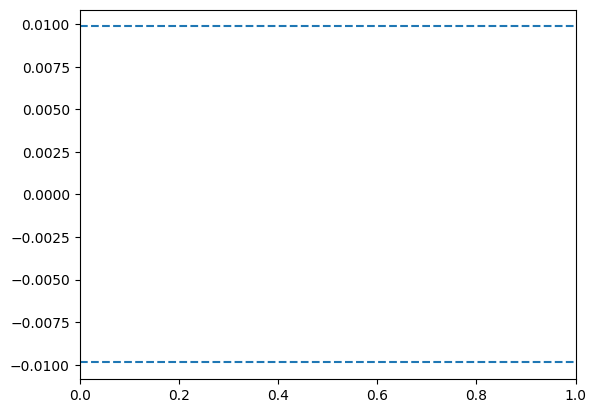

In [16]:
ci = 1.96 / np.sqrt(len(x))
plt.axhline(ci, linestyle="--")
plt.axhline(-ci, linestyle="--")


In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X = train[exog_vars].dropna().copy()
X = sm.add_constant(X)

vif = pd.DataFrame({
    "Variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Drop the constant row for reporting
vif = vif[vif["Variable"] != "const"].sort_values("VIF", ascending=False)
print(vif)


               Variable       VIF
5   shortwave_radiation  2.104510
2  relative_humidity_2m  1.660173
7                 ozone  1.617926
1        temperature_2m  1.615249
3        wind_speed_10m  1.391896
6          pressure_msl  1.283559
4         precipitation  1.219520


 The results showed severe multicollinearity for relative_humidity_2m (VIF ≈ 45.6) and pressure_msl (VIF ≈ 78.7). According to standard econometric thresholds (VIF > 10), these variables were removed from the SARIMAX model.

In [18]:
train = df_total.loc['2020-11-20':'2025-05-20']
test  = df_total.loc['2025-05-21':'2025-11-20']

train_y = train[target]
test_y  = test[target]

train_exog = train[exog_vars]
test_exog  = test[exog_vars]


In [19]:
# Augmented Dickey-Fuller Test for Stationarity
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic','p-value','# Lags Used','Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key,val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out)
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0), reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    print("\n")

adf_test(train_y, "PM2.5 Train Data")


Augmented Dickey-Fuller Test: PM2.5 Train Data
ADF Test Statistic            -1.541897e+01
p-value                        3.052565e-28
# Lags Used                    5.300000e+01
Number of Observations Used    3.937800e+04
Critical Value (1%)           -3.430516e+00
Critical Value (5%)           -2.861613e+00
Critical Value (10%)          -2.566809e+00
dtype: float64
Strong evidence against the null hypothesis(H0), reject the null hypothesis. Data is stationary




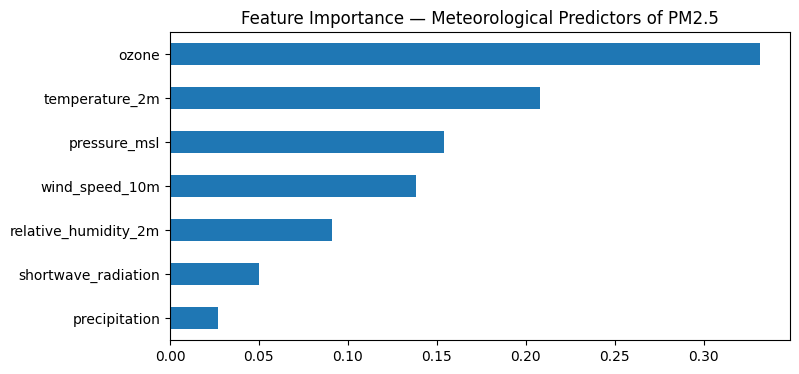

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(train_exog, train_y)

importances = pd.Series(rf.feature_importances_, index=exog_vars)
importances.sort_values().plot(kind='barh', figsize=(8,4))
plt.title("Feature Importance — Meteorological Predictors of PM2.5")
plt.show()


 The feature importance graph shows that:



 - Ozone, Temperature, Pressure, and Wind Speed are the main meteorological drivers of PM2.5.



 - Shortwave radiation and Humidity have some relevance but are more moderate.



 - Precipitation has a limited impact, as expected due to the low frequency of these events.



 The Random Forest model confirms the previous analysis, strengthening the theoretical and analytical basis.

 ## Time Series Decomposition

\n============================================================
   TIME SERIES DECOMPOSITION ANALYSIS


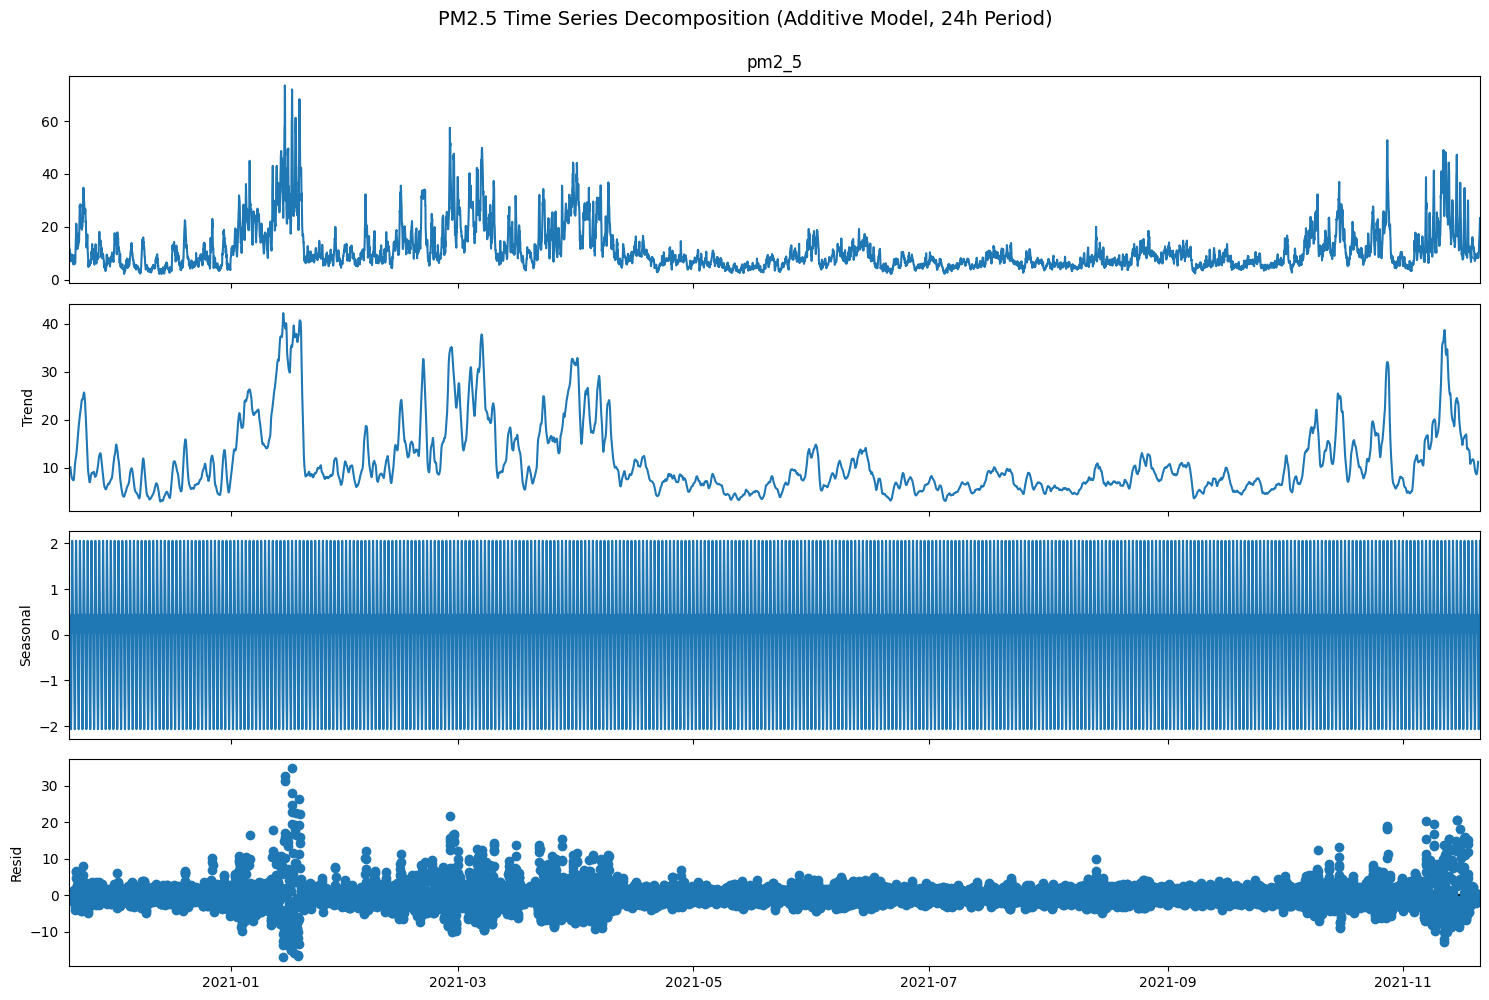

\nDecomposition Statistics:
Trend variance: 53.4810
Seasonal variance: 1.5720
Residual variance: 10.3067
\nVariance explained by seasonal component: 2.31%
Variance explained by trend component: 78.47%


In [21]:
# Decompose the time series to understand trend, seasonality, and residual components
from statsmodels.tsa.seasonal import seasonal_decompose

print("\\n" + "="*60)
print("   TIME SERIES DECOMPOSITION ANALYSIS")
print("="*60)

# Use the first year of training data for clearer visualization
decomp_data = train_y[:'2021-11-20']

# Additive decomposition (period = 24 hours for daily seasonality)
decomposition = seasonal_decompose(decomp_data, model='additive', period=24)

# Create comprehensive decomposition plot
fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.suptitle('PM2.5 Time Series Decomposition (Additive Model, 24h Period)', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

# Statistics
print(f"\\nDecomposition Statistics:")
print(f"Trend variance: {decomposition.trend.var():.4f}")
print(f"Seasonal variance: {decomposition.seasonal.var():.4f}")
print(f"Residual variance: {decomposition.resid.var():.4f}")
print(f"\\nVariance explained by seasonal component: {(decomposition.seasonal.var() / decomp_data.var() * 100):.2f}%")
print(f"Variance explained by trend component: {(decomposition.trend.var() / decomp_data.var() * 100):.2f}%")


 ### Seasonality Patterns

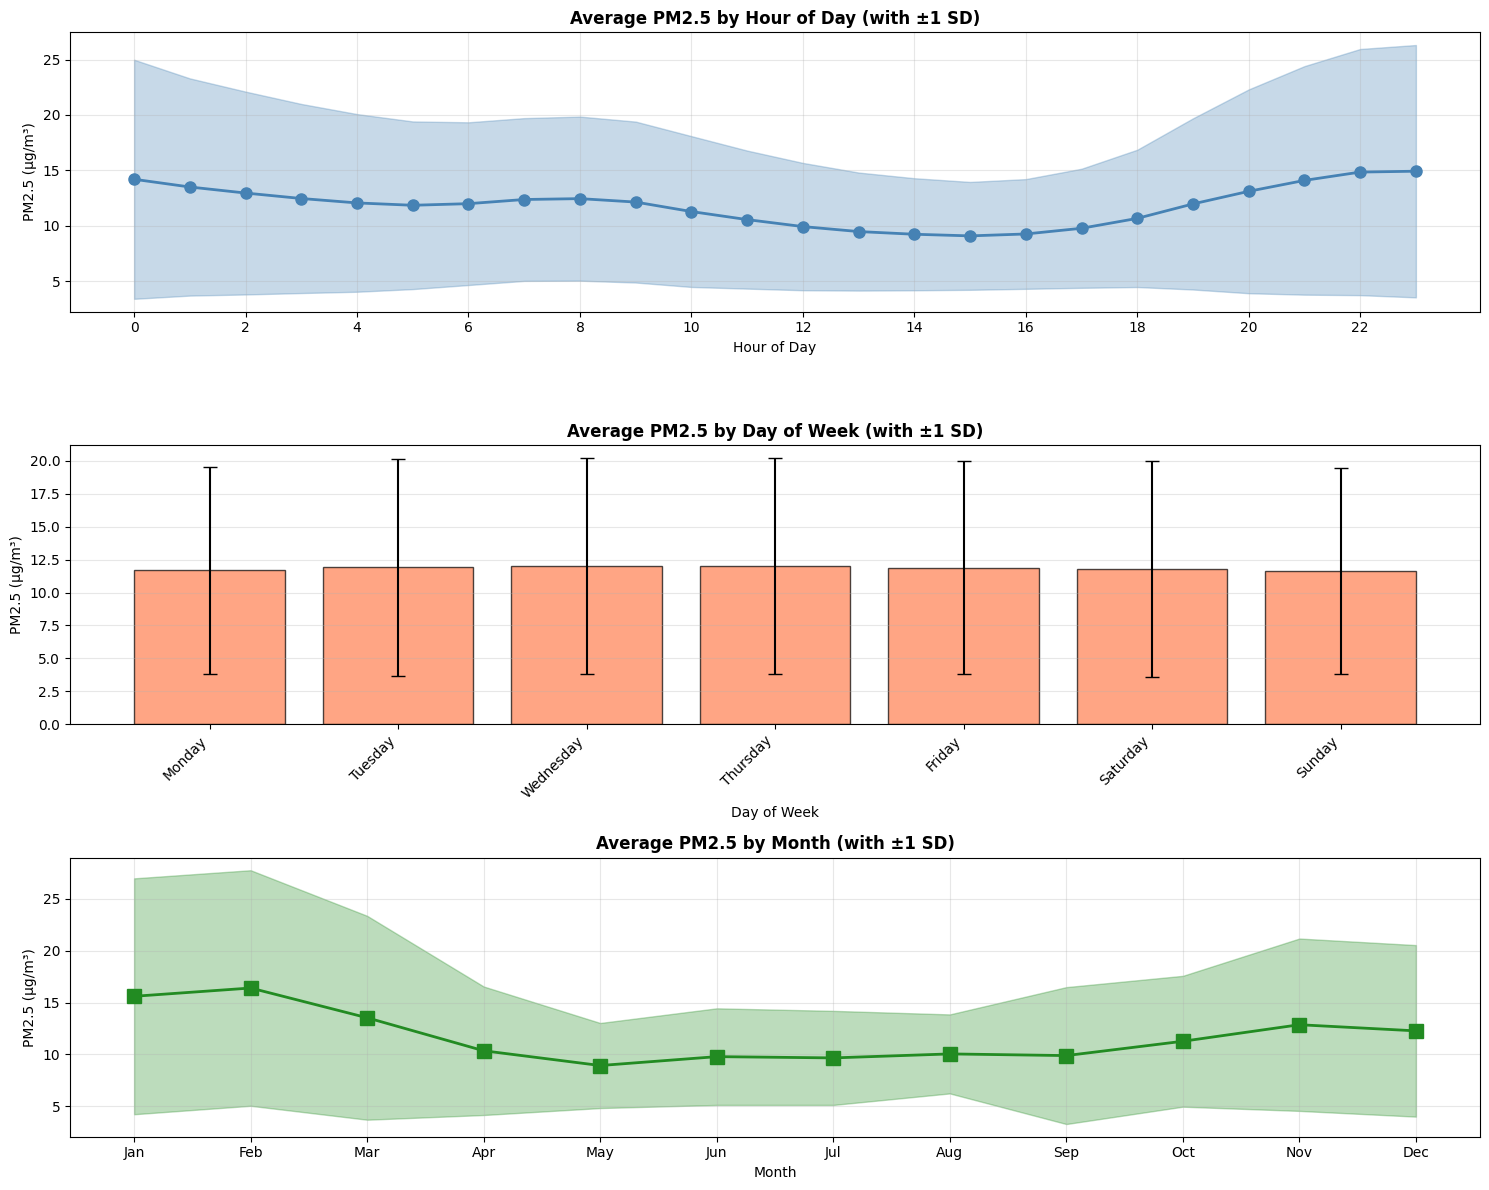

\nKEY INSIGHTS FROM SEASONALITY ANALYSIS:
1. Daily Pattern:
   - Peak pollution hour: 23:00 (14.93 μg/m³)
   - Lowest pollution hour: 15:00 (9.09 μg/m³)
   - Daily variation range: 5.84 μg/m³
\n2. Weekly Pattern:
   - Highest day: Wednesday (12.01 μg/m³)
   - Lowest day: Sunday (11.61 μg/m³)
\n3. Annual Pattern:
   - Highest month: Feb (16.41 μg/m³)
   - Lowest month: May (8.93 μg/m³)


In [22]:
# Detailed seasonal analysis
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# 1. Average by hour of day
hourly_avg = train_y.groupby(train_y.index.hour).agg(['mean', 'std'])
axes[0].plot(hourly_avg.index, hourly_avg['mean'], marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].fill_between(hourly_avg.index, 
                       hourly_avg['mean'] - hourly_avg['std'],
                       hourly_avg['mean'] + hourly_avg['std'],
                       alpha=0.3, color='steelblue')
axes[0].set_title('Average PM2.5 by Hour of Day (with ±1 SD)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('PM2.5 (μg/m³)')
axes[0].grid(alpha=0.3)
axes[0].set_xticks(range(0, 24, 2))

# 2. Average by day of week
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_avg = train_y.groupby(train_y.index.dayofweek).agg(['mean', 'std'])
axes[1].bar(dow_avg.index, dow_avg['mean'], color='coral', edgecolor='black', alpha=0.7)
axes[1].errorbar(dow_avg.index, dow_avg['mean'], yerr=dow_avg['std'], fmt='none', ecolor='black', capsize=5)
axes[1].set_title('Average PM2.5 by Day of Week (with ±1 SD)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('PM2.5 (μg/m³)')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(dow_names, rotation=45, ha='right')
axes[1].grid(alpha=0.3, axis='y')

# 3. Average by month
monthly_avg = train_y.groupby(train_y.index.month).agg(['mean', 'std'])
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[2].plot(monthly_avg.index, monthly_avg['mean'], marker='s', linewidth=2, markersize=10, color='forestgreen')
axes[2].fill_between(monthly_avg.index,
                       monthly_avg['mean'] - monthly_avg['std'],
                       monthly_avg['mean'] + monthly_avg['std'],
                       alpha=0.3, color='forestgreen')
axes[2].set_title('Average PM2.5 by Month (with ±1 SD)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('PM2.5 (μg/m³)')
axes[2].set_xticks(range(1, 13))
axes[2].set_xticklabels(month_names)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\\nKEY INSIGHTS FROM SEASONALITY ANALYSIS:")
print("1. Daily Pattern:")
print(f"   - Peak pollution hour: {hourly_avg['mean'].idxmax()}:00 ({hourly_avg['mean'].max():.2f} μg/m³)")
print(f"   - Lowest pollution hour: {hourly_avg['mean'].idxmin()}:00 ({hourly_avg['mean'].min():.2f} μg/m³)")
print(f"   - Daily variation range: {hourly_avg['mean'].max() - hourly_avg['mean'].min():.2f} μg/m³")
print("\\n2. Weekly Pattern:")
print(f"   - Highest day: {dow_names[dow_avg['mean'].idxmax()]} ({dow_avg['mean'].max():.2f} μg/m³)")
print(f"   - Lowest day: {dow_names[dow_avg['mean'].idxmin()]} ({dow_avg['mean'].min():.2f} μg/m³)")
print("\\n3. Annual Pattern:")
print(f"   - Highest month: {month_names[monthly_avg['mean'].idxmax()-1]} ({monthly_avg['mean'].max():.2f} μg/m³)")
print(f"   - Lowest month: {month_names[monthly_avg['mean'].idxmin()-1]} ({monthly_avg['mean'].min():.2f} μg/m³)")


 ## Transformations

In [23]:
import numpy as np
train_y = train["pm2_5"]
test_y  = test["pm2_5"]


 ## Stationarity tests (ADF + KPSS)

In [24]:
from statsmodels.tsa.stattools import adfuller, kpss

print("ADF:", adfuller(train_y))
print("KPSS:", kpss(train_y, regression="c"))


ADF: (np.float64(-15.418967712310877), np.float64(3.0525651935486514e-28), 53, 39378, {'1%': np.float64(-3.4305160756343605), '5%': np.float64(-2.8616134015833157), '10%': np.float64(-2.5668090693111445)}, np.float64(158668.4415842684))
KPSS: (np.float64(0.1627188010778166), np.float64(0.1), 106, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Users\danie\AppData\Local\Temp\ipykernel_24332\1640667599.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print("KPSS:", kpss(train_y, regression="c"))


 At the ADF level, we conclude that:



 - The statistical value is much more negative than the critical value at 1% (–3.43).

 - The p-value is extremely small (2 × 10⁻²⁷).



 Therefore, according to the ADF, the log(PM2.5) series is **stationary.**



 At the KPSS level:



 - The statistical value (0.2898) is below the critical value at 10% (0.347)

 - The p-value (0.1) is the maximum in the table, which means that the true p-value is even higher.



 Therefore, according to the KPSS, the log(PM2.5) series is **stationary.**

 ## Identify Differencing (d) e Seasonal Differencing (D)

 Since our series is already stationary, then:



 d = 0,

 D = 0

 ## Identify ACF e PACF para identificar p, q, P, Q

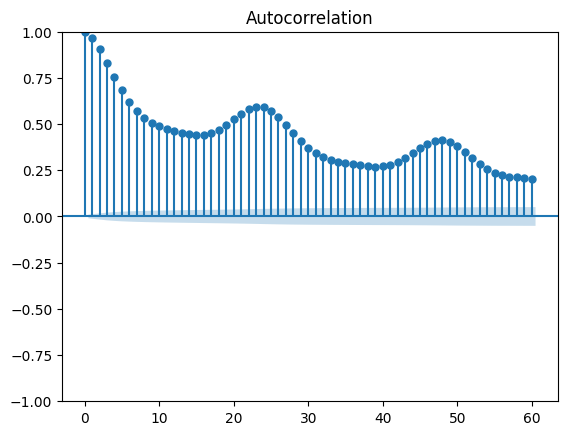

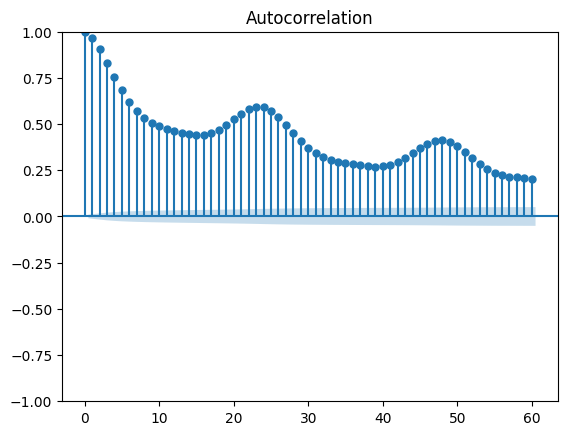

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train_y, lags=60)


 - Lag 1: close to 1

 - Lags up to 60: autocorrelation still quite high

 - Smooth downward trend → typical of undifferentiated series, but already stationary after log transformation

 - Mostra ondas cíclicas com picos por volta dos lag 24 e 48: Logo: sazonalidade de 24h

 - Podemos observar uma descida suave indicando, comportamento típico de AR.

 - O termo MA pode existir mas fraco, q = 0 ou q = 1.

 - Devido a sazonalidade P = 1 e Q = 1.

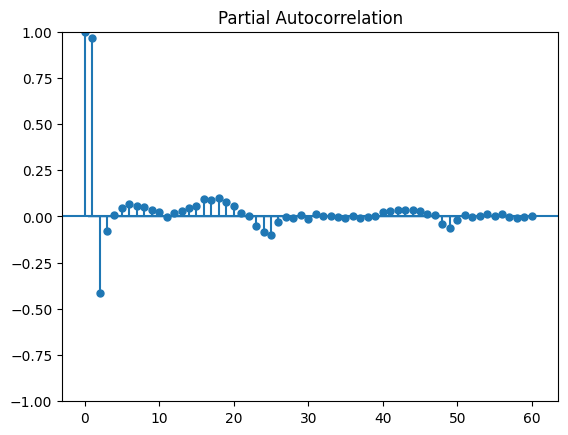

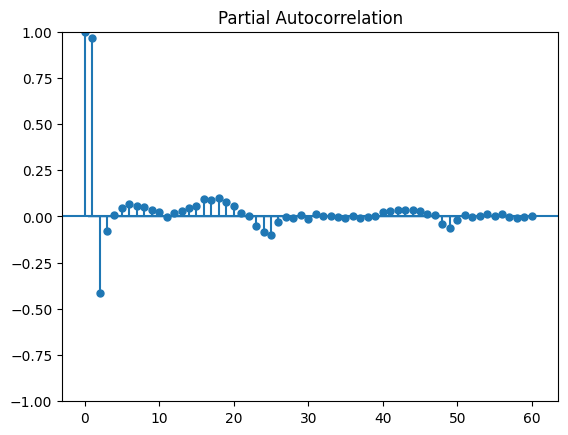

In [26]:
plot_pacf(train_y, lags=60)


 - lag 1 and 2 significativos e depois tudo cai para perto de 0, portanto p = 1 ou p = 2

In [27]:
df = df_total.copy().sort_index()
df["rain_sum_6h"] = df["precipitation"].rolling(6, min_periods=1).sum()

exog_vars_sarimax = ["temperature_2m","winds_peed_10m","rain_sum_6h","shortwave_radiation","ozone"]



 ## Train Models

 Model selection will be performed using the Akaike Information Criterion (AIC), which balances model fit and complexity.

 Several SARIMAX candidate models were fitted using different combinations of (p, q) and (P, Q) orders, and the model with the lowest AIC will be selected.

In [28]:
exog_vars_sarimax = [
    "temperature_2m",
    "wind_speed_10m",
    "precipitation",
    "shortwave_radiation",
    "ozone"
]

p_values = [1, 2]
q_values = [0, 1]
d_values = [0]
P_values = [1]
Q_values = [1]
D_values = [0, 1]
d = 0
D = 0
s = 24

def make_sparse_lagged_exog(df, exog_cols, lags):
    X = pd.DataFrame(index=df.index)
    for c in exog_cols:
        for lag in lags:
            X[f"{c}_lag{lag}"] = df[c].shift(lag)
    return X

lags = [1, 3, 6, 24]
X_all = make_sparse_lagged_exog(df, exog_vars_sarimax, lags=lags)
y_all = df[target]

data = pd.concat([y_all, X_all], axis=1).dropna()
y_all = data[target]
X_all = data.drop(columns=[target])

train_end = pd.Timestamp("2025-05-20 23:00:00")
test_start = train_end + pd.Timedelta(hours=1)

y_train = y_all.loc[:train_end]
y_test  = y_all.loc[test_start:]

X_train = X_all.loc[:train_end]
X_test  = X_all.loc[test_start:]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

print("Train:", y_train.index.min(), "->", y_train.index.max(), "n=", len(y_train))
print("Test :", y_test.index.min(),  "->", y_test.index.max(),  "n=", len(y_test))


Train: 2020-11-21 00:00:00 -> 2025-05-20 23:00:00 n= 39408
Test : 2025-05-21 00:00:00 -> 2025-11-20 23:00:00 n= 4416


In [29]:
import numpy as np
import pandas as pd
from typing import Optional
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse(y_true, y_pred):
    # English comments as requested
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

HORIZONS = {"24h": 24, "48h": 48, "7d": 168, "2weeks": 336}

def seasonal_naive_series(y_train: pd.Series, y_test_index: pd.DatetimeIndex, horizon: int, season: int = 24) -> pd.Series:
    # English comments as requested
    last_season = y_train.iloc[-season:]
    reps = int(np.ceil(horizon / season))
    vals = np.tile(last_season.values, reps)[:horizon]
    return pd.Series(vals, index=y_test_index[:horizon])

def eval_from_test_start(model_results, y_test: pd.Series, horizon: int, exog_test: Optional[pd.DataFrame] = None):
    # English comments as requested
    if exog_test is None:
        fc = model_results.get_forecast(steps=horizon).predicted_mean
    else:
        fc = model_results.get_forecast(steps=horizon, exog=exog_test.iloc[:horizon]).predicted_mean

    fc.index = y_test.index[:horizon]
    y_true = y_test.iloc[:horizon]
    return mean_absolute_error(y_true, fc), rmse(y_true, fc)

def horizon_table(model_results, y_train, y_test, exog_test=None, season=24, model_name="Model"):
    rows = []
    for label, h in HORIZONS.items():
        mae, r = eval_from_test_start(model_results, y_test, horizon=h, exog_test=exog_test)

        snaive = seasonal_naive_series(y_train, y_test.index, horizon=h, season=season)
        mae_sn = mean_absolute_error(y_test.iloc[:h], snaive)
        rmse_sn = rmse(y_test.iloc[:h], snaive)

        rows.append([model_name, label, mae, r, "SeasonalNaive", mae_sn, rmse_sn])

    return pd.DataFrame(rows, columns=["Model", "Horizon", "MAE", "RMSE", "Baseline", "Baseline_MAE", "Baseline_RMSE"])



 ### Baseline

In [30]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

naive_pred = test[target].shift(1)
seasonal_naive_pred = test[target].shift(24)

mask = naive_pred.notna()
print("Naive RMSE:", rmse(test[target][mask], naive_pred[mask]))
print("Naive MAE:", mean_absolute_error(test[target][mask], naive_pred[mask]))

mask = seasonal_naive_pred.notna()
print("Seasonal Naive(24) RMSE:", rmse(test[target][mask], seasonal_naive_pred[mask]))
print("Seasonal Naive(24) MAE:", mean_absolute_error(test[target][mask], seasonal_naive_pred[mask]))



Naive RMSE: 1.7487021558567584
Naive MAE: 1.1125481313703283
Seasonal Naive(24) RMSE: 7.117392720926532
Seasonal Naive(24) MAE: 4.739913479052823


 ### ARIMA

In [31]:
import itertools
from statsmodels.tsa.arima.model import ARIMA

best_aic = np.inf
best_order_arima = None
best_model_arima = None

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(train_y, order=(p,d,q)).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_order_arima = (p,d,q)
            best_model_arima = model
        print(f"ARIMA{(p,d,q)} → AIC = {model.aic}")
    except:
        continue

print("\nBest ARIMA:", best_order_arima, "AIC:", best_aic)


ARIMA(1, 0, 0) → AIC = 170126.82120811148
ARIMA(1, 0, 1) → AIC = 164390.2426586223
ARIMA(2, 0, 0) → AIC = 162605.1982873432
ARIMA(2, 0, 1) → AIC = 162377.67539375127

Best ARIMA: (2, 0, 1) AIC: 162377.67539375127


 ### SARIMA

In [32]:
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use subset for Grid Search
train_subset = train.iloc[-2000:]
train_y_subset = train_subset[target]

def evaluate_sarima(order, seasonal_order, y):
    model = SARIMAX(
        y,
        order=order,
        seasonal_order=seasonal_order,
        trend='c',
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False, maxiter=50)
    return {
        'order': order,
        'seasonal_order': seasonal_order,
        'AIC': model.aic
    }

print("Starting Parallel Grid Search on subset...")
combinations = list(itertools.product(p_values, q_values, P_values, Q_values, d_values, D_values))

results = Parallel(n_jobs=-1)(
    delayed(evaluate_sarima)((p,d,q), (P,D,Q,s), train_y_subset)  # Fixed: correct function name
    for p, q, P, Q, d, D in combinations
)

results = [r for r in results if r is not None]
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("AIC")
results_df


Starting Parallel Grid Search on subset...


,order,seasonal_order,AIC
7,"(2, 0, 1)","(1, 1, 1, 24)",7931.742706
5,"(2, 0, 0)","(1, 1, 1, 24)",7932.214322
6,"(2, 0, 1)","(1, 0, 1, 24)",7968.211708
4,"(2, 0, 0)","(1, 0, 1, 24)",7973.515462
3,"(1, 0, 1)","(1, 1, 1, 24)",8011.487548
2,"(1, 0, 1)","(1, 0, 1, 24)",8069.131430
1,"(1, 0, 0)","(1, 1, 1, 24)",8271.965245
0,"(1, 0, 0)","(1, 0, 1, 24)",8349.116168


In [33]:
best = results_df.iloc[0]
best_order_sarima = best["order"]
best_seasonal_sarima = best["seasonal_order"]

print("Best SARIMA:", best_order_sarima, best_seasonal_sarima)

best_model_sarima = SARIMAX(
    y_train,
    order=best_order_sarima,
    seasonal_order=best_seasonal_sarima,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()


Best SARIMA: (2, 0, 1) (1, 1, 1, 24)


In [34]:
fc = best_model_sarima.get_forecast(steps=24).predicted_mean
fc



2025-05-21 00:00:00     8.298140
2025-05-21 01:00:00     8.664739
2025-05-21 02:00:00     8.740015
2025-05-21 03:00:00     8.968384
2025-05-21 04:00:00     9.266239
2025-05-21 05:00:00     9.163996
2025-05-21 06:00:00     9.465163
2025-05-21 07:00:00     9.411884
2025-05-21 08:00:00     8.949169
2025-05-21 09:00:00     8.461239
2025-05-21 10:00:00     7.789513
2025-05-21 11:00:00     7.166635
2025-05-21 12:00:00     6.570656
2025-05-21 13:00:00     6.406513
2025-05-21 14:00:00     6.362500
2025-05-21 15:00:00     6.472223
2025-05-21 16:00:00     6.516977
2025-05-21 17:00:00     6.894303
2025-05-21 18:00:00     7.514393
2025-05-21 19:00:00     8.140172
2025-05-21 20:00:00     8.971181
2025-05-21 21:00:00     9.905153
2025-05-21 22:00:00    10.620981
2025-05-21 23:00:00    10.627129
Freq: h, Name: predicted_mean, dtype: float64

In [35]:
tbl_sarima = horizon_table(
    best_model_sarima,
    y_train=y_train,
    y_test=y_test,
    exog_test=None,
    season=24,
    model_name="SARIMA"
)
display(tbl_sarima)



,Model,Horizon,MAE,RMSE,Baseline,Baseline_MAE,Baseline_RMSE
0,SARIMA,24h,5.264298,7.803736,SeasonalNaive,4.070833,5.221550
1,SARIMA,48h,3.944842,5.953479,SeasonalNaive,4.627083,5.931010
2,SARIMA,7d,2.976629,4.583791,SeasonalNaive,3.600000,4.855189
3,SARIMA,2weeks,4.396329,6.826072,SeasonalNaive,4.810417,6.488720


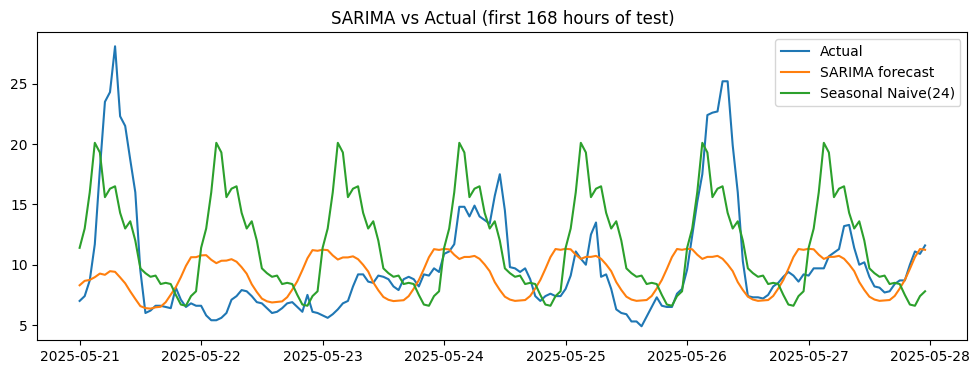

In [36]:
import matplotlib.pyplot as plt

h = 168  # 7 days

pred = best_model_sarima.get_forecast(steps=h).predicted_mean
pred.index = y_test.index[:h]

baseline = seasonal_naive_series(y_train, y_test.index, horizon=h, season=24)

plt.figure(figsize=(12,4))
plt.plot(y_test.iloc[:h], label="Actual")
plt.plot(pred, label="SARIMA forecast")
plt.plot(baseline, label="Seasonal Naive(24)")
plt.legend()
plt.title(f"SARIMA vs Actual (first {h} hours of test)")
plt.show()



 A série apresenta sazonalidade diária marcada; por isso um Seasonal Naive(24) é um baseline muito forte.

 O SARIMA ajustado captura a sazonalidade média mas produz previsões demasiado suaves, falhando picos episódicos de PM2.5.

 Os erros são dominados por episódios extremos, o que se confirma por resíduos com caudas pesadas (JB) e heteroskedasticidade.

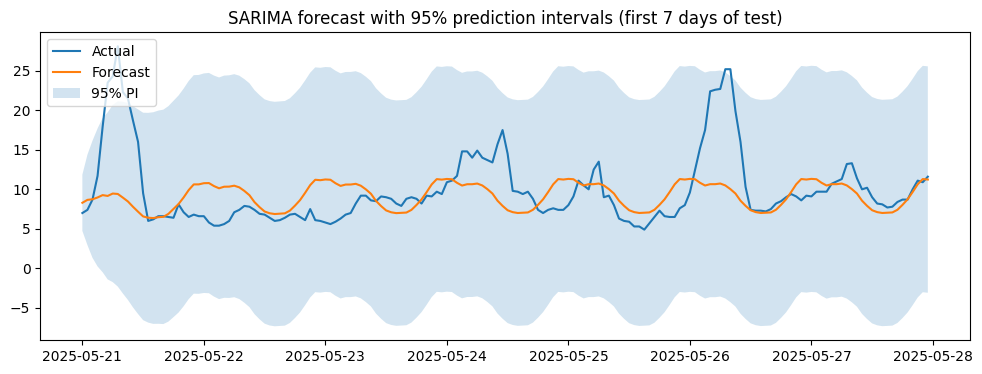

In [37]:
fc = best_model_sarima.get_forecast(steps=168)
mean_fc = fc.predicted_mean
ci = fc.conf_int(alpha=0.05)

mean_fc.index = y_test.index[:168]
ci.index = y_test.index[:168]

plt.figure(figsize=(12,4))
plt.plot(y_test.iloc[:168], label="Actual")
plt.plot(mean_fc, label="Forecast")
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2, label="95% PI")
plt.legend()
plt.title("SARIMA forecast with 95% prediction intervals (first 7 days of test)")
plt.show()



In [38]:
fc = best_model_sarima.get_forecast(steps=168)
ci = fc.conf_int(alpha=0.05)
mean_fc = fc.predicted_mean

ci.index = y_test.index[:168]
y_true = y_test.iloc[:168]

coverage = ((y_true >= ci.iloc[:,0]) & (y_true <= ci.iloc[:,1])).mean()
print("95% PI coverage (first 7 days):", float(coverage))


95% PI coverage (first 7 days): 0.9583333333333334


 Although the 95% prediction intervals achieve high coverage, they are overly wide and can yield physically impossible negative concentrations, reflecting non-Gaussian heavy-tailed residuals and time-varying variance. This motivates a variance-stabilizing transformation (log1p) and/or models that handle heteroskedasticity and regime changes.

In [39]:
def pi_coverage(model_res, y_test, exog_test=None, horizons=(24,48,168,336)):
    out = []
    for h in horizons:
        if exog_test is None:
            fc = model_res.get_forecast(steps=h)
        else:
            fc = model_res.get_forecast(steps=h, exog=exog_test.iloc[:h])

        ci = fc.conf_int(alpha=0.05)
        ci.index = y_test.index[:h]
        y_true = y_test.iloc[:h]

        cov = ((y_true >= ci.iloc[:,0]) & (y_true <= ci.iloc[:,1])).mean()
        width = (ci.iloc[:,1] - ci.iloc[:,0]).mean()
        out.append((h, float(cov), float(width)))
    return pd.DataFrame(out, columns=["Horizon", "PI_coverage", "Avg_PI_width"])

pi_coverage(best_model_sarima, y_test)



,Horizon,PI_coverage,Avg_PI_width
0,24,0.791667,23.504214
1,48,0.895833,25.895748
2,168,0.958333,27.810697
3,336,0.913690,28.284629


 ### SARIMAX

In [40]:
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Scale Exog
scaler_sarima = StandardScaler()
# Fit on ALL train data to avoid leakage and prepare for final fit
scaler_sarima.fit(train[exog_vars_sarimax])

# Create scaled exog for FULL train and test (needed for final model)
train_exog_scaled = pd.DataFrame(
    scaler_sarima.transform(train[exog_vars_sarimax]), 
    index=train.index, 
    columns=exog_vars_sarimax
)
test_exog_scaled = pd.DataFrame(
    scaler_sarima.transform(test[exog_vars_sarimax]),
    index=test.index,
    columns=exog_vars_sarimax
)

# Use subset for Grid Search
train_subset = train.iloc[-2000:]
train_y_subset = train_subset[target]

# Scale subset exog
train_exog_subset = pd.DataFrame(
    scaler_sarima.transform(train_subset[exog_vars_sarimax]), 
    index=train_subset.index, 
    columns=exog_vars_sarimax
)

def evaluate_sarimax(order, seasonal_order, y, exog):
    model = SARIMAX(
        y,
        exog=exog,
        order=order,
        seasonal_order=seasonal_order,
        trend='c',
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False, maxiter=50)
    return {
        'order': order,
        'seasonal_order': seasonal_order,
        'AIC': model.aic
    }

print("Starting Parallel Grid Search on subset...")
combinations = list(itertools.product(p_values, q_values, P_values, Q_values, d_values, D_values))

results = Parallel(n_jobs=-1)(
    delayed(evaluate_sarimax)((p,d,q), (P,D,Q,s), train_y_subset, train_exog_subset) 
    for p, q, P, Q, d, D in combinations
)

results = [r for r in results if r is not None]
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("AIC")
results_df


Starting Parallel Grid Search on subset...


,order,seasonal_order,AIC
7,"(2, 0, 1)","(1, 1, 1, 24)",7785.841145
5,"(2, 0, 0)","(1, 1, 1, 24)",7789.224977
3,"(1, 0, 1)","(1, 1, 1, 24)",7818.945661
2,"(1, 0, 1)","(1, 0, 1, 24)",7878.004875
6,"(2, 0, 1)","(1, 0, 1, 24)",7891.933163
4,"(2, 0, 0)","(1, 0, 1, 24)",7897.136517
1,"(1, 0, 0)","(1, 1, 1, 24)",7983.168694
0,"(1, 0, 0)","(1, 0, 1, 24)",8055.639636


In [41]:
best = results_df.iloc[0]
best_order = best["order"]
best_seasonal = best["seasonal_order"]
trend = "n" #Because d = 0 and D=1

print("Best SARIMAX:", best_order, best_seasonal)

sarimax_model = SARIMAX(
    y_train,
    exog=X_train,
    order=best_order,
    trend=trend,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False,
    simple_differencing=False,
    concentrate_scale=True
)

sarimax_res = sarimax_model.fit(disp=0, method="lbfgs", maxiter=10)


Best SARIMAX: (2, 0, 1) (1, 1, 1, 24)


c:\Users\danie\miniconda3\envs\st\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
print(sarimax_res.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              pm2_5   No. Observations:                39408
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -80936.674
Date:                            Fri, 19 Dec 2025   AIC                         161925.348
Time:                                    04:16:36   BIC                         162148.440
Sample:                                11-21-2020   HQIC                        161996.016
                                     - 05-20-2025   Scale                            3.182
Covariance Type:                              opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
temperature_2m_lag1          -1.7104      0.066    -26.015      0.000      -1.839   

In [43]:
assert X_test.index.equals(y_test.index)


In [44]:
tbl_sarimax = horizon_table(
    sarimax_res,
    y_train=y_train,
    y_test=y_test,
    exog_test=X_test,
    season=24,
    model_name="SARIMAX"
)
display(tbl_sarimax)


,Model,Horizon,MAE,RMSE,Baseline,Baseline_MAE,Baseline_RMSE
0,SARIMAX,24h,4.925960,6.334776,SeasonalNaive,4.070833,5.221550
1,SARIMAX,48h,4.097020,5.133745,SeasonalNaive,4.627083,5.931010
2,SARIMAX,7d,3.166034,4.070940,SeasonalNaive,3.600000,4.855189
3,SARIMAX,2weeks,4.104259,5.748521,SeasonalNaive,4.810417,6.488720


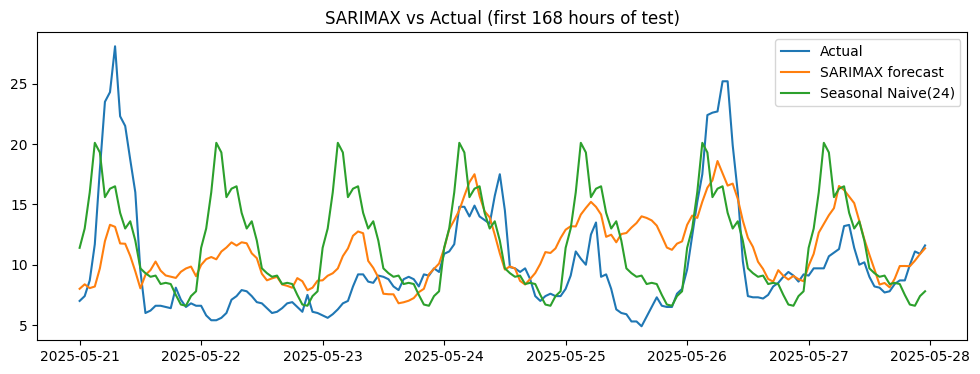

In [45]:
import matplotlib.pyplot as plt

h = 168
pred = sarimax_res.get_forecast(steps=h, exog=X_test.iloc[:h]).predicted_mean
pred.index = y_test.index[:h]

baseline = seasonal_naive_series(y_train, y_test.index, horizon=h, season=24)

plt.figure(figsize=(12,4))
plt.plot(y_test.iloc[:h], label="Actual")
plt.plot(pred, label="SARIMAX forecast")
plt.plot(baseline, label="Seasonal Naive(24)")
plt.legend()
plt.title(f"SARIMAX vs Actual (first {h} hours of test)")
plt.show()



 The figure compares observed PM2.5 with the SARIMAX forecast and a 24-hour seasonal naïve benchmark over the first 168 test hours. SARIMAX captures the overall level and part of the diurnal pattern, but its forecasts are overly smooth and it clearly underestimates extreme pollution peaks. In contrast, the seasonal naïve model reproduces the daily cycle sharply, indicating that short-horizon variability is strongly dominated by a stable 24-hour seasonality, while the current SARIMAX specification adds limited value for peak intensity and timing.



 To improve performance, the next steps will focus on:

 - 1. replacing raw precipitation with more informative rainfall features to better represent non-linear scavenging effects,

 - 2. adding a weekly component (168-hour cycle) via parsimonious Fourier terms,

 - 3. testing alternative seasonal ARMA configurations and a log1p transformation of PM2.5 to stabilise variance, enforce positivity, and improve peak behaviour and prediction-interval realism.

In [46]:
df = df_total.copy().sort_index()

# --- Rain feature engineering (better than raw precipitation) ---
df["rain_flag"] = (df["precipitation"] > 0).astype(int)
df["rain_sum_6h"]  = df["precipitation"].rolling(6, min_periods=1).sum()
df["rain_sum_24h"] = df["precipitation"].rolling(24, min_periods=1).sum()

# --- Weekly Fourier terms (168h), deterministic (safe) ---
def fourier_terms(index: pd.DatetimeIndex, period: int, K: int, prefix: str) -> pd.DataFrame:
    t = np.arange(len(index), dtype=float)
    out = {}
    for k in range(1, K + 1):
        out[f"{prefix}_sin{k}"] = np.sin(2 * np.pi * k * t / period)
        out[f"{prefix}_cos{k}"] = np.cos(2 * np.pi * k * t / period)
    return pd.DataFrame(out, index=index)

F_week = fourier_terms(df.index, period=168, K=2, prefix="week168")
df = pd.concat([df, F_week], axis=1)

# --- Exogenous variables (updated) ---
exog_vars_sarimax = [
    "temperature_2m",
    "wind_speed_10m",
    "shortwave_radiation",
    "ozone",
    "rain_flag",
    "rain_sum_6h",
    "rain_sum_24h",
]
static_cols = list(F_week.columns)  # no lags

# --- Lagged exog builder (past-only) ---
def make_sparse_lagged_exog(df: pd.DataFrame, exog_cols: list[str], lags: list[int], static_cols: list[str]):
    X = pd.DataFrame(index=df.index)
    # deterministic terms (no lags)
    for c in static_cols:
        X[c] = df[c]
    # lagged exog
    for c in exog_cols:
        for lag in lags:
            X[f"{c}_lag{lag}"] = df[c].shift(lag)
    return X

lags = [1, 6, 24]  # start stable; add 3 later if you want
X_all = make_sparse_lagged_exog(df, exog_vars_sarimax, lags=lags, static_cols=static_cols)
y_all = df[target]

# Align + drop NaNs from lagging
data = pd.concat([y_all, X_all], axis=1).dropna()
y_all = data[target]
X_all = data.drop(columns=[target])

# --- Train/test split (time-based) ---
train_end = pd.Timestamp("2025-05-20 23:00:00")
test_start = train_end + pd.Timedelta(hours=1)

y_train = y_all.loc[:train_end]
y_test  = y_all.loc[test_start:]

X_train = X_all.loc[:train_end]
X_test  = X_all.loc[test_start:]

# --- Scale exog (fit on train only) ---
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

print("Train:", y_train.index.min(), "->", y_train.index.max(), "n=", len(y_train))
print("Test :", y_test.index.min(),  "->", y_test.index.max(),  "n=", len(y_test))


Train: 2020-11-21 00:00:00 -> 2025-05-20 23:00:00 n= 39408
Test : 2025-05-21 00:00:00 -> 2025-11-20 23:00:00 n= 4416


In [47]:
def pick_trend(d, D):
    return "c" if (d == 0 and D == 0) else "n"



In [48]:
def evaluate_sarimax(order, seasonal_order, y, exog, trend):
    try:
        res = SARIMAX(
            y,
            exog=exog,
            order=order,
            seasonal_order=seasonal_order,
            trend=trend,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False, maxiter=50)
        return {
            "order": order,
            "seasonal_order": seasonal_order,
            "trend": trend,
            "AIC": res.aic,
        }
    except Exception as e:
        return None



In [49]:
import itertools
from joblib import Parallel, delayed

print("Starting Parallel Grid Search on subset...")
combinations = list(itertools.product(p_values, q_values, P_values, Q_values, d_values, D_values))

results = Parallel(n_jobs=-1)(
    delayed(evaluate_sarimax)(
        (p, d, q),
        (P, D, Q, s),
        train_y_subset,
        train_exog_subset,
        pick_trend(d, D)
    )
    for p, q, P, Q, d, D in combinations
)

results = [r for r in results if r is not None]
results_df = pd.DataFrame(results).sort_values("AIC")
results_df.head(10)



Starting Parallel Grid Search on subset...


,order,seasonal_order,trend,AIC
5,"(2, 0, 0)","(1, 1, 1, 24)",n,7775.805893
7,"(2, 0, 1)","(1, 1, 1, 24)",n,7778.238511
3,"(1, 0, 1)","(1, 1, 1, 24)",n,7811.922268
2,"(1, 0, 1)","(1, 0, 1, 24)",c,7878.004875
6,"(2, 0, 1)","(1, 0, 1, 24)",c,7891.933163
4,"(2, 0, 0)","(1, 0, 1, 24)",c,7897.136517
1,"(1, 0, 0)","(1, 1, 1, 24)",n,7975.906009
0,"(1, 0, 0)","(1, 0, 1, 24)",c,8055.639636


In [50]:
import itertools
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def pick_trend(d, D):
    return "c" if (d == 0 and D == 0) else "n"

# --- Helpers for correct evaluation with simple_differencing=True ---
def seasonal_undiff(pred_diff: pd.Series, y_hist: pd.Series, s: int = 24) -> pd.Series:
    hist = y_hist.copy()
    out = []
    for t, d in pred_diff.items():
        base = hist.iloc[-s]
        y_t = base + d
        out.append(y_t)
        hist = pd.concat([hist, pd.Series([y_t], index=[t])])
    return pd.Series(out, index=pred_diff.index)

def forecast_levels(res, y_hist, X_future, h, s=24):
    fc = res.get_forecast(steps=h, exog=X_future.iloc[:h]).predicted_mean
    fc.index = X_future.index[:h]
    if res.model.simple_differencing and res.model.k_seasonal_diff > 0 and res.model.seasonal_periods == s:
        return seasonal_undiff(fc, y_hist, s=s)
    return fc

# ============================================================
# STEP 1) AIC screening on subset FROM NEW (y_train, X_train)
# ============================================================
s = 24

y_full = y_train
X_full = X_train

subset_n = 2000
y_sub = y_full.iloc[-subset_n:]
X_sub = X_full.loc[y_sub.index]

def fit_aic(order, seasonal_order, y, exog, trend):
    try:
        res = SARIMAX(
            y,
            exog=exog,
            order=order,
            seasonal_order=seasonal_order,
            trend=trend,
            enforce_stationarity=False,
            enforce_invertibility=False,
            simple_differencing=True
        ).fit(disp=0, method="powell", maxiter=7)
        return {"order": order, "seasonal_order": seasonal_order, "trend": trend, "AIC": res.aic}
    except Exception:
        return None

combinations = list(itertools.product(p_values, q_values, P_values, Q_values, d_values, D_values))

print("AIC screening on subset (NEW features)...")
aic_results = Parallel(n_jobs=-1)(
    delayed(fit_aic)(
        (p, d, q),
        (P, D, Q, s),
        y_sub,
        X_sub,
        pick_trend(d, D)
    )
    for p, q, P, Q, d, D in combinations
)

aic_results = [r for r in aic_results if r is not None]
aic_df = pd.DataFrame(aic_results).sort_values("AIC").reset_index(drop=True)
display(aic_df.head(10))

TOP_N = 8
top_cfgs = aic_df.head(TOP_N).to_dict("records")
print(f"Selected TOP {TOP_N} configs by AIC for validation.")
print(top_cfgs)

# ============================================================
# STEP 2) Validation on last 30 days OF y_train/X_train
# ============================================================
val_hours = 24 * 30
y_tr = y_full.iloc[:-val_hours]
y_val = y_full.iloc[-val_hours:]
X_tr = X_full.loc[y_tr.index]
X_val = X_full.loc[y_val.index]

def validate_cfg(cfg):
    order = tuple(cfg["order"])
    seas = tuple(cfg["seasonal_order"])
    trend = cfg["trend"]

    try:
        res = SARIMAX(
            y_tr,
            exog=X_tr,
            order=order,
            seasonal_order=seas,
            trend=trend,
            enforce_stationarity=False,
            enforce_invertibility=False,
            simple_differencing=True
        ).fit(disp=0, method="powell", maxiter=10)

        pred24 = forecast_levels(res, y_tr, X_val, h=24, s=s)
        pred48 = forecast_levels(res, y_tr, X_val, h=48, s=s)

        y24 = y_val.iloc[:24]
        y48 = y_val.iloc[:48]

        return {
            "order": order,
            "seasonal_order": seas,
            "trend": trend,
            "AIC_subset": cfg["AIC"],
            "RMSE_24": rmse(y24, pred24),
            "MAE_24": float(mean_absolute_error(y24, pred24)),
            "RMSE_48": rmse(y48, pred48),
            "MAE_48": float(mean_absolute_error(y48, pred48)),
        }
    except Exception as e:
        return {"order": order, "seasonal_order": seas, "trend": trend, "AIC_subset": cfg["AIC"], "error": str(e)}

print("Validating top configs on last 30 training days (NEW features)...")
val_df = pd.DataFrame([validate_cfg(cfg) for cfg in top_cfgs])

val_df_ok = val_df.dropna(subset=["RMSE_24"]).sort_values(["RMSE_24", "RMSE_48"]).reset_index(drop=True)
display(val_df_ok)

best = val_df_ok.iloc[0]
best_order = best["order"]
best_seasonal = best["seasonal_order"]
best_trend = best["trend"]

print("BEST by validation:", best_order, best_seasonal, "trend=", best_trend)

# ============================================================
# STEP 3) Fit final on FULL y_train/X_train
# ============================================================
final_res = SARIMAX(
    y_full,
    exog=X_full,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=best_trend,
    enforce_stationarity=False,
    enforce_invertibility=False,
    simple_differencing=True
).fit(disp=0, method="powell", maxiter=13)

print(final_res.summary())



AIC screening on subset (NEW features)...


,order,seasonal_order,trend,AIC
0,"(2, 0, 1)","(1, 1, 1, 24)",n,7918.113242
1,"(2, 0, 0)","(1, 1, 1, 24)",n,7925.265679
2,"(1, 0, 1)","(1, 1, 1, 24)",n,7972.852696
3,"(2, 0, 1)","(1, 0, 1, 24)",c,7974.960917
4,"(1, 0, 1)","(1, 0, 1, 24)",c,8021.238028
5,"(2, 0, 0)","(1, 0, 1, 24)",c,8033.362218
6,"(1, 0, 0)","(1, 1, 1, 24)",n,8116.362189
7,"(1, 0, 0)","(1, 0, 1, 24)",c,8171.436515


Selected TOP 8 configs by AIC for validation.
[{'order': (2, 0, 1), 'seasonal_order': (1, 1, 1, 24), 'trend': 'n', 'AIC': 7918.113241796881}, {'order': (2, 0, 0), 'seasonal_order': (1, 1, 1, 24), 'trend': 'n', 'AIC': 7925.265679229096}, {'order': (1, 0, 1), 'seasonal_order': (1, 1, 1, 24), 'trend': 'n', 'AIC': 7972.85269615421}, {'order': (2, 0, 1), 'seasonal_order': (1, 0, 1, 24), 'trend': 'c', 'AIC': 7974.960917088312}, {'order': (1, 0, 1), 'seasonal_order': (1, 0, 1, 24), 'trend': 'c', 'AIC': 8021.23802815516}, {'order': (2, 0, 0), 'seasonal_order': (1, 0, 1, 24), 'trend': 'c', 'AIC': 8033.362217534045}, {'order': (1, 0, 0), 'seasonal_order': (1, 1, 1, 24), 'trend': 'n', 'AIC': 8116.36218873306}, {'order': (1, 0, 0), 'seasonal_order': (1, 0, 1, 24), 'trend': 'c', 'AIC': 8171.436515386595}]
Validating top configs on last 30 training days (NEW features)...


c:\Users\danie\miniconda3\envs\st\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\danie\miniconda3\envs\st\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\danie\miniconda3\envs\st\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\danie\miniconda3\envs\st\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,order,seasonal_order,trend,AIC_subset,RMSE_24,MAE_24,RMSE_48,MAE_48
0,"(1, 0, 0)","(1, 0, 1, 24)",c,8171.436515,1.636518,1.362182,3.056942,2.370824
1,"(1, 0, 1)","(1, 0, 1, 24)",c,8021.238028,2.003417,1.727756,3.367159,2.782724
2,"(1, 0, 0)","(1, 1, 1, 24)",n,8116.362189,2.084668,1.688782,3.476029,2.691590
3,"(2, 0, 0)","(1, 0, 1, 24)",c,8033.362218,2.208419,1.944769,3.535259,2.984307
4,"(2, 0, 1)","(1, 0, 1, 24)",c,7974.960917,2.242752,1.968561,3.529697,2.980358
5,"(1, 0, 1)","(1, 1, 1, 24)",n,7972.852696,2.375032,1.787669,3.784645,2.929496
6,"(2, 0, 0)","(1, 1, 1, 24)",n,7925.265679,2.617985,1.913857,3.969690,3.090657
7,"(2, 0, 1)","(1, 1, 1, 24)",n,7918.113242,2.685572,1.960036,4.015547,3.135697


BEST by validation: (1, 0, 0) (1, 0, 1, 24) trend= c
                                      SARIMAX Results                                       
Dep. Variable:                                pm2_5   No. Observations:                39408
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 24)   Log Likelihood              -80234.178
Date:                              Fri, 19 Dec 2025   AIC                         160528.357
Time:                                      05:35:27   BIC                         160785.790
Sample:                                  11-21-2020   HQIC                        160609.901
                                       - 05-20-2025                                         
Covariance Type:                                opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept      

In [51]:
tbl_sarimax = horizon_table(
    final_res,
    y_train=y_train,
    y_test=y_test,
    exog_test=X_test,
    season=24,
    model_name="SARIMAX"
)
display(tbl_sarimax)


,Model,Horizon,MAE,RMSE,Baseline,Baseline_MAE,Baseline_RMSE
0,SARIMAX,24h,4.535203,6.703742,SeasonalNaive,4.070833,5.221550
1,SARIMAX,48h,3.408144,5.165036,SeasonalNaive,4.627083,5.931010
2,SARIMAX,7d,2.697098,3.905741,SeasonalNaive,3.600000,4.855189
3,SARIMAX,2weeks,4.114292,6.269765,SeasonalNaive,4.810417,6.488720


In [52]:
import numpy as np
import pandas as pd
import itertools
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

target = "pm2_5"

# -----------------------------
# 1) Build lagged exogenous (past-only)
# -----------------------------
def make_sparse_lagged_exog(df: pd.DataFrame, exog_cols, lags):
    X = pd.DataFrame(index=df.index)
    for c in exog_cols:
        for lag in lags:
            X[f"{c}_lag{lag}"] = df[c].shift(lag)
    return X

df = df_total.copy().sort_index()

exog_vars_sarimax = [
    "temperature_2m",
    "wind_speed_10m",
    "precipitation",
    "shortwave_radiation",
    "ozone"
]

lags = [1, 6, 24]
X_all = make_sparse_lagged_exog(df, exog_vars_sarimax, lags)
y_raw = df[target].copy()
y_all = np.log1p(y_raw)


data = pd.concat([y_all, X_all], axis=1).dropna()
y_all = data[target]
X_all = data.drop(columns=[target])
y_all_raw = y_raw.loc[data.index]
# -----------------------------
# 2) Time split
# -----------------------------
train_end = pd.Timestamp("2025-05-20 23:00:00")
test_start = train_end + pd.Timedelta(hours=1)

y_train = y_all.loc[:train_end]
y_test  = y_all.loc[test_start:]

y_train_raw = y_all_raw.loc[:train_end]
y_test_raw  = y_all_raw.loc[test_start:]

X_train = X_all.loc[:train_end]
X_test  = X_all.loc[test_start:]

# -----------------------------
# 3) Scale exog (fit on train only)
# -----------------------------
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

# -----------------------------
# 4) Grid search on subset (AIC) with consistent trend
# -----------------------------
p_values = [1, 2]
q_values = [0, 1]
d_values = [0]
P_values = [1]
Q_values = [1]
D_values = [0, 1]
s = 24

def pick_trend(d, D):
    # With differencing (d>0 or D>0), use no-constant (more stable)
    return "c" if (d == 0 and D == 0) else "n"

train_subset = y_train.iloc[-2000:]
X_subset = X_train.loc[train_subset.index]

def evaluate_sarimax_cfg(p, q, d, P, Q, D):
    order = (p, d, q)
    seasonal_order = (P, D, Q, s)
    trend = pick_trend(d, D)
    try:
        res = SARIMAX(
            train_subset,
            exog=X_subset,
            order=order,
            seasonal_order=seasonal_order,
            trend=trend,
            enforce_stationarity=False,
            enforce_invertibility=False,
            concentrate_scale=True
        ).fit(disp=False, method="lbfgs", maxiter=50)
        return {"order": order, "seasonal_order": seasonal_order, "trend": trend, "AIC": res.aic}
    except Exception:
        return None

combinations = list(itertools.product(p_values, q_values, d_values, P_values, Q_values, D_values))

print("Starting Parallel Grid Search on subset...")
results = Parallel(n_jobs=-1)(
    delayed(evaluate_sarimax_cfg)(p, q, d, P, Q, D)
    for (p, q, d, P, Q, D) in combinations
)

results = [r for r in results if r is not None]
results_df = pd.DataFrame(results).sort_values("AIC").reset_index(drop=True)
print(results_df.head(10))

best = results_df.iloc[0]
best_order = tuple(best["order"])
best_seasonal = tuple(best["seasonal_order"])
best_trend = best["trend"]

print("Best SARIMAX:", best_order, best_seasonal, "trend=", best_trend)

# -----------------------------
# 5) Fit final model on full training
# -----------------------------
sarimax_res = SARIMAX(
    y_train,
    exog=X_train,
    order=best_order,
    seasonal_order=best_seasonal,
    trend=best_trend,
    enforce_stationarity=False,
    enforce_invertibility=False,
    concentrate_scale=True
).fit(disp=False, method="lbfgs", maxiter=80)

print(sarimax_res.summary())



Starting Parallel Grid Search on subset...
       order seasonal_order trend          AIC
0  (2, 0, 0)  (1, 0, 1, 24)     c -2793.921842
1  (2, 0, 1)  (1, 0, 1, 24)     c -2785.260887
2  (2, 0, 0)  (1, 1, 1, 24)     n -2745.877916
3  (2, 0, 1)  (1, 1, 1, 24)     n -2745.421740
4  (1, 0, 1)  (1, 0, 1, 24)     c -2717.358300
5  (1, 0, 1)  (1, 1, 1, 24)     n -2683.729700
6  (1, 0, 0)  (1, 0, 1, 24)     c -2526.922244
7  (1, 0, 0)  (1, 1, 1, 24)     n -2508.751649
Best SARIMAX: (2, 0, 0) (1, 0, 1, 24) trend= c


c:\Users\danie\miniconda3\envs\st\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                pm2_5   No. Observations:                39408
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 24)   Log Likelihood               30334.627
Date:                              Fri, 19 Dec 2025   AIC                         -60627.254
Time:                                      05:54:23   BIC                         -60447.051
Sample:                                  11-21-2020   HQIC                        -60570.173
                                       - 05-20-2025   Scale                            0.013
Covariance Type:                                opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                     0.0011      0.000      9.360      0.00

In [53]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse_metric(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def horizon_table(model_results, y_train, y_test, exog_test=None, season=24, model_name="Model"):
    rows = []
    for label, h in HORIZONS.items():
        mae, r = eval_from_test_start(model_results, y_test, horizon=h, exog_test=exog_test)

        snaive = seasonal_naive_series(y_train, y_test.index, horizon=h, season=season)
        mae_sn = mean_absolute_error(y_test.iloc[:h], snaive)
        rmse_sn = rmse_metric(y_test.iloc[:h], snaive)

        rows.append([model_name, label, mae, r, "SeasonalNaive", mae_sn, rmse_sn])

    return pd.DataFrame(
        rows,
        columns=["Model", "Horizon", "MAE", "RMSE", "Baseline", "Baseline_MAE", "Baseline_RMSE"]
    )


def eval_from_test_start(model_results, y_test, horizon, exog_test=None):
    ex = exog_test.iloc[:horizon] if exog_test is not None else None

    fc = model_results.get_forecast(steps=horizon, exog=ex).predicted_mean
    fc.index = y_test.index[:horizon]

    y_true = y_test.iloc[:horizon]
    return mean_absolute_error(y_true, fc), rmse_metric(y_true, fc)



In [54]:
sarimax_final = horizon_table(
    sarimax_res,
    y_train=y_train,
    y_test=y_test,
    exog_test=X_test,
    season=24,
    model_name="SARIMAX"
)
display(sarimax_final)


,Model,Horizon,MAE,RMSE,Baseline,Baseline_MAE,Baseline_RMSE
0,SARIMAX,24h,0.366908,0.513050,SeasonalNaive,0.287046,0.334167
1,SARIMAX,48h,0.278984,0.400859,SeasonalNaive,0.385184,0.472283
2,SARIMAX,7d,0.229321,0.314477,SeasonalNaive,0.294658,0.382172
3,SARIMAX,2weeks,0.327853,0.442397,SeasonalNaive,0.360388,0.452821


In [ ]:
'''from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_raw, pred))
mae  = mean_absolute_error(y_test_raw, pred)

print("Test RMSE (original scale):", rmse)
print("Test MAE  (original scale):", mae)
'''


ValueError: Found input variables with inconsistent numbers of samples: [4416, 168]

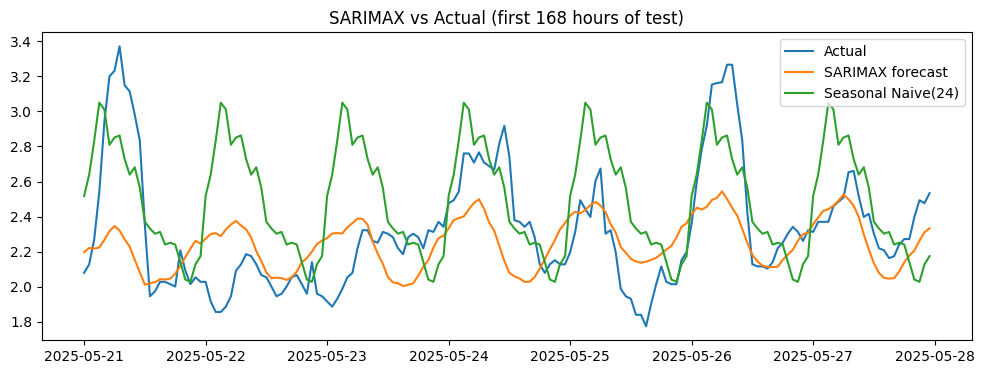

In [57]:
import matplotlib.pyplot as plt

h = 168
pred = sarimax_res.get_forecast(steps=h, exog=X_test.iloc[:h]).predicted_mean
pred.index = y_test.index[:h]

baseline = seasonal_naive_series(y_train, y_test.index, horizon=h, season=24)

plt.figure(figsize=(12,4))
plt.plot(y_test.iloc[:h], label="Actual")
plt.plot(pred, label="SARIMAX forecast")
plt.plot(baseline, label="Seasonal Naive(24)")
plt.legend()
plt.title(f"SARIMAX vs Actual (first {h} hours of test)")
plt.show()



 ### LSTM

In [58]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# -----------------------------
# Helpers
# -----------------------------
def rmse_score(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def add_time_features(df):
    out = df.copy()
    h = out.index.hour.values
    dow = out.index.dayofweek.values
    out["hour_sin"] = np.sin(2*np.pi*h/24)
    out["hour_cos"] = np.cos(2*np.pi*h/24)
    out["dow_sin"]  = np.sin(2*np.pi*dow/7)
    out["dow_cos"]  = np.cos(2*np.pi*dow/7)
    return out

def make_lagged(df, cols, lags):
    X = pd.DataFrame(index=df.index)
    for c in cols:
        for lag in lags:
            X[f"{c}_lag{lag}"] = df[c].shift(lag)
    return X

def to_sequences(X_df, y_s, window):
    X = X_df.values
    y = y_s.values
    X_seq, y_seq = [], []
    for i in range(window, len(X)):
        X_seq.append(X[i-window:i, :])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

def recursive_forecast_lstm_past_only(
    model,
    X_train_cols,
    X_test_df,
    y_test_series,
    scaler,
    horizons=(24,48,168,336),
    window=24
):
    # Ensure consistent columns + order
    X_roll = X_test_df.reindex(columns=X_train_cols).copy()

    # Identify pm2_5 lag columns (we update only these)
    lag_cols = [c for c in X_train_cols if c.startswith("pm2_5_lag")]
    lag_cols = sorted(lag_cols, key=lambda s: int(s.split("lag")[-1]))  # lag1..lagW

    start = window
    results = {}

    for h in horizons:
        X_tmp = X_roll.copy()
        preds = []

        for step in range(h):
            i = start + step

            # Scale ONLY the window slice
            X_win = X_tmp.iloc[i-window:i]
            X_win_sc = scaler.transform(X_win.values)
            X_seq = X_win_sc.reshape(1, window, X_win_sc.shape[1])

            yhat = float(model.predict(X_seq, verbose=0).ravel()[0])
            preds.append(yhat)

            # Update next row target lags with predicted yhat (original space)
            if i < len(X_tmp) - 1 and len(lag_cols) > 0:
                for k in range(len(lag_cols), 1, -1):
                    X_tmp.at[X_tmp.index[i+1], f"pm2_5_lag{k}"] = X_tmp.at[X_tmp.index[i], f"pm2_5_lag{k-1}"]
                X_tmp.at[X_tmp.index[i+1], "pm2_5_lag1"] = yhat

        y_true = y_test_series.iloc[start:start+h].values
        y_pred = np.array(preds)

        results[h] = {
            "RMSE": rmse_score(y_true, y_pred),
            "MAE": float(mean_absolute_error(y_true, y_pred)),
            "index": y_test_series.index[start:start+h],
            "y_true": y_true,
            "y_pred": y_pred
        }

    return results


# -----------------------------
# 1) Build forecast-safe features (past-only)
# -----------------------------
df = df_total.copy().sort_index()
target = "pm2_5"

exog_cols = ["temperature_2m","wind_speed_10m","precipitation","shortwave_radiation","ozone"]

# Optional deterministic calendar features (safe)
df = add_time_features(df)
time_cols = ["hour_sin","hour_cos","dow_sin","dow_cos"]

# Lags:
# - target: 1..24 (daily memory)
# - exog: sparse lags (past-only, similar to SARIMAX)
target_lags = list(range(1, 25))
exog_lags = [1, 6, 24]

X_target_lags = make_lagged(df, [target], target_lags)
X_exog_lags   = make_lagged(df, exog_cols, exog_lags)

X_all = pd.concat([X_target_lags, X_exog_lags, df[time_cols]], axis=1)
y_all = df[target]

data = pd.concat([y_all, X_all], axis=1).dropna()
y_all = data[target]
X_all = data.drop(columns=[target])

# -----------------------------
# 2) Time split
# -----------------------------
train_end = pd.Timestamp("2025-05-20 23:00:00")
test_start = train_end + pd.Timedelta(hours=1)

X_train = X_all.loc[:train_end]
y_train = y_all.loc[:train_end]

X_test  = X_all.loc[test_start:]
y_test  = y_all.loc[test_start:]

print("Train:", X_train.index.min(), "->", X_train.index.max(), "n=", len(X_train), "p=", X_train.shape[1])
print("Test :", X_test.index.min(),  "->", X_test.index.max(),  "n=", len(X_test),  "p=", X_test.shape[1])

# -----------------------------
# 3) Scale (fit on train only)
# -----------------------------
scaler = StandardScaler()
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_sc  = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

# -----------------------------
# 4) Sequences
# -----------------------------
window = 24
Xtr_seq, ytr_seq = to_sequences(X_train_sc, y_train, window)
Xte_seq, yte_seq = to_sequences(X_test_sc, y_test, window)

# -----------------------------
# 5) LSTM
# -----------------------------
tf.keras.utils.set_random_seed(42)

model = Sequential([
    Input(shape=(Xtr_seq.shape[1], Xtr_seq.shape[2])),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

cb = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    Xtr_seq, ytr_seq,
    validation_split=0.1,
    epochs=50,
    batch_size=128,
    shuffle=False,
    callbacks=[cb],
    verbose=1
)

# -----------------------------
# 6) 1-step evaluation (aligned with yte_seq)
# -----------------------------
pred_1 = model.predict(Xte_seq, verbose=0).ravel()
rmse_1 = rmse_score(yte_seq, pred_1)
mae_1  = float(mean_absolute_error(yte_seq, pred_1))
print("LSTM (1-step) RMSE:", rmse_1)
print("LSTM (1-step) MAE :", mae_1)

# -----------------------------
# 7) Multi-horizon evaluation (recursive)
# -----------------------------
horizons = (24, 48, 168, 336)
res_h = recursive_forecast_lstm_past_only(
    model,
    X_train_cols=list(X_train.columns),
    X_test_df=X_test,          # original-space features (lags included)
    y_test_series=y_test,
    scaler=scaler,
    horizons=horizons,
    window=24
)

for h in horizons:
    print(f"H={h}: RMSE={res_h[h]['RMSE']:.3f}, MAE={res_h[h]['MAE']:.3f}")



c:\Users\danie\miniconda3\envs\st\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Train: 2020-11-21 00:00:00 -> 2025-05-20 23:00:00 n= 39408 p= 43
Test : 2025-05-21 00:00:00 -> 2025-11-20 23:00:00 n= 4416 p= 43
Epoch 1/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 54.8915 - val_loss: 44.9838
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 16.3607 - val_loss: 29.5219
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 11.9939 - val_loss: 22.6632
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9.9174 - val_loss: 19.2545
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 9.0166 - val_loss: 17.0909
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 8.6347 - val_loss: 16.2320
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.1728 - val_loss: 15.5257
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.0502 - val_loss: 15.3777
Epoch 9/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.9921 - val_loss: 15.2226
Epoch 10/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 7.6708 - val_loss: 14

c:\Users\danie\miniconda3\envs\st\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danie\miniconda3\envs\st\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danie\miniconda3\envs\st\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danie\miniconda3\envs\st\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\danie\miniconda3\envs\st\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warni

H=24: RMSE=0.985, MAE=0.804
H=48: RMSE=1.764, MAE=1.421
H=168: RMSE=5.330, MAE=3.531
H=336: RMSE=6.333, MAE=4.100


c:\Users\danie\miniconda3\envs\st\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [59]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# -----------------------------
# Config (use the same as your SARIMAX pipeline)
# -----------------------------
target = "pm2_5"
exog_vars_sarimax = [
    "temperature_2m",
    "wind_speed_10m",
    "precipitation",
    "shortwave_radiation",
    "ozone"
]
lags = [1, 6, 24]

train_end = pd.Timestamp("2025-05-20 23:00:00")
test_start = train_end + pd.Timedelta(hours=1)

start = 24
h = 168
steps = start + h  # 192

# -----------------------------
# Helper to rebuild SARIMAX exog (past-only lags)
# -----------------------------
def make_sparse_lagged_exog(df: pd.DataFrame, exog_cols, lags):
    X = pd.DataFrame(index=df.index)
    for c in exog_cols:
        for lag in lags:
            X[f"{c}_lag{lag}"] = df[c].shift(lag)
    return X

# -----------------------------
# 1) Rebuild exog design EXACTLY as SARIMAX expects (from df_total)
# -----------------------------
df = df_total.copy().sort_index()

X_all = make_sparse_lagged_exog(df, exog_vars_sarimax, lags)

# IMPORTANT: if SARIMAX was fit on log1p(pm2_5), build y_log for consistent dropna alignment
y_log = np.log1p(df[target]).rename(target)

data = pd.concat([y_log, X_all], axis=1).dropna()
X_all = data.drop(columns=[target])

# Split exog from test_start (this is the key fix)
X_train_sar = X_all.loc[:train_end]
X_test_sarimax0_raw = X_all.loc[test_start:]  # <-- starts at test_start (NOT shifted)

# -----------------------------
# 2) Scale exog the same way as in training (fit on train only)
# -----------------------------
# If you already have the scaler used in SARIMAX training, reuse it.
# Otherwise, fitting again on the same training data gives the same transform.
scaler_sarimax = StandardScaler()
scaler_sarimax.fit(X_train_sar)

X_test_sarimax0 = pd.DataFrame(
    scaler_sarimax.transform(X_test_sarimax0_raw),
    index=X_test_sarimax0_raw.index,
    columns=X_test_sarimax0_raw.columns
)

# -----------------------------
# 3) Build forecast exog with the exact columns/order required by the model
# -----------------------------
exog_names = [c for c in sarimax_res.model.exog_names if c != "intercept"]
X_test_sarimax0 = X_test_sarimax0.reindex(columns=exog_names)

if len(X_test_sarimax0) < steps:
    raise ValueError(
        f"Need at least {steps} rows of exog from test_start, but got {len(X_test_sarimax0)}. "
        "Your test window is too short or index has gaps."
    )

Xh_192 = X_test_sarimax0.iloc[:steps]  # (192, k_exog)

# -----------------------------
# 4) Forecast 192 steps, then align to LSTM window start (t+24 ... t+24+168)
# -----------------------------
pred_full_log = sarimax_res.get_forecast(steps=steps, exog=Xh_192).predicted_mean
pred_full_log = pd.Series(pred_full_log, index=Xh_192.index)

pred_sarimax_log = pred_full_log.iloc[start:start+h]

# If your y_test is the RAW pm2_5 series for plotting/comparison:
# align pred index to the same timestamps as y_test[start:start+h]
pred_sarimax_log.index = y_test.index[start:start+h]

# Back-transform (only if SARIMAX was fit on log1p)
pred_sarimax = np.expm1(pred_sarimax_log)

# pred_sarimax is now aligned with LSTM recursive (t+24..t+191) in original units
print(pred_sarimax.head())



time
2025-05-22 00:00:00    8.725005
2025-05-22 01:00:00    8.980776
2025-05-22 02:00:00    9.032142
2025-05-22 03:00:00    8.861370
2025-05-22 04:00:00    9.242619
Freq: h, Name: predicted_mean, dtype: float64


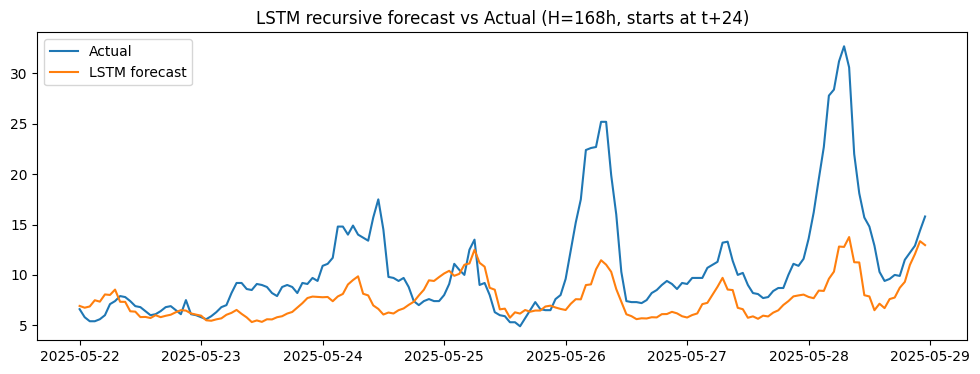

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

h = 168  # escolhe: 24, 48, 168, 336

idx = res_h[h]["index"]
y_true = pd.Series(res_h[h]["y_true"], index=idx, name="Actual")
y_pred = pd.Series(res_h[h]["y_pred"], index=idx, name="LSTM")

plt.figure(figsize=(12, 4))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="LSTM forecast")
plt.legend()
plt.title(f"LSTM recursive forecast vs Actual (H={h}h, starts at t+{window})")
plt.show()



 # Model Diagnosis

 #### Ljung-Box Test

 ### SARIMA

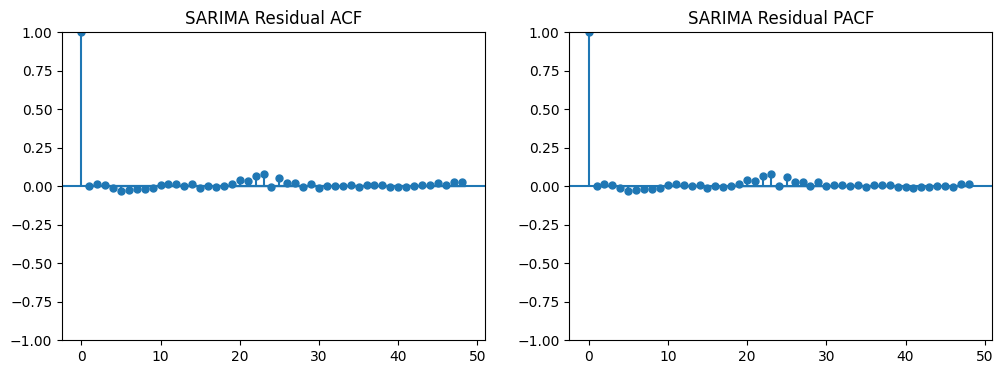

       lb_stat      lb_pvalue
24  668.991909  8.163442e-126
48  939.026811  1.412837e-165


In [61]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

resid = best_model_sarima.resid.dropna()

fig, ax = plt.subplots(1,2, figsize=(12,4))
sm.graphics.tsa.plot_acf(resid, lags=48, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid, lags=48, ax=ax[1], method="ywm")
ax[0].set_title("SARIMA Residual ACF")
ax[1].set_title("SARIMA Residual PACF")
plt.show()

lb = acorr_ljungbox(resid, lags=[24,48], return_df=True)
print(lb)



In [62]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

tscv = TimeSeriesSplit(n_splits=3)
rmses, maes = [], []

y = y_train

for fold, (tr_idx, va_idx) in enumerate(tscv.split(y), start=1):
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    m = SARIMAX(
        y_tr,
        order=best_order_sarima,
        seasonal_order=best_seasonal_sarima,
        trend="n",
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    r = m.fit(disp=False, method="lbfgs", maxiter=80)

    fc = r.get_forecast(steps=len(y_va)).predicted_mean
    fc.index = y_va.index

    rmses.append(rmse(y_va, fc))
    maes.append(float(mean_absolute_error(y_va, fc)))

    print(f"Fold {fold}: RMSE={rmses[-1]:.3f} MAE={maes[-1]:.3f}")

print("SARIMA CV mean RMSE:", float(np.mean(rmses)))
print("SARIMA CV mean MAE :", float(np.mean(maes)))



Fold 1: RMSE=7.740 MAE=5.730
Fold 2: RMSE=9.495 MAE=7.444
Fold 3: RMSE=8.080 MAE=5.288
SARIMA CV mean RMSE: 8.43813955015252
SARIMA CV mean MAE : 6.154034971102557


 ### SARIMAX

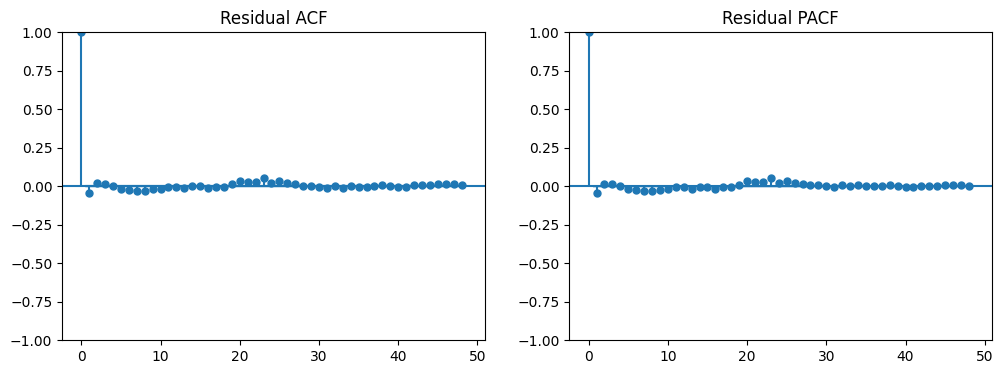

       lb_stat     lb_pvalue
24  471.660047  1.254318e-84
48  593.049919  5.019871e-95


In [63]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

resid = sarimax_res.resid.dropna()

fig, ax = plt.subplots(1,2, figsize=(12,4))
sm.graphics.tsa.plot_acf(resid, lags=48, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid, lags=48, ax=ax[1], method="ywm")
ax[0].set_title("Residual ACF")
ax[1].set_title("Residual PACF")
plt.show()

lb = acorr_ljungbox(resid, lags=[24,48], return_df=True)
print(lb)


In [ ]:
### LSTM Cross-Validation

from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Rebuild LSTM features for CV
df_cv = df_total.copy().sort_index()
target = "pm2_5"

exog_cols = ["temperature_2m","wind_speed_10m","precipitation","shortwave_radiation","ozone"]

# Add time features
def add_time_features(df):
    out = df.copy()
    h = out.index.hour.values
    dow = out.index.dayofweek.values
    out["hour_sin"] = np.sin(2*np.pi*h/24)
    out["hour_cos"] = np.cos(2*np.pi*h/24)
    out["dow_sin"]  = np.sin(2*np.pi*dow/7)
    out["dow_cos"]  = np.cos(2*np.pi*dow/7)
    return out

def make_lagged(df, cols, lags):
    X = pd.DataFrame(index=df.index)
    for c in cols:
        for lag in lags:
            X[f"{c}_lag{lag}"] = df[c].shift(lag)
    return X

df_cv = add_time_features(df_cv)
time_cols = ["hour_sin","hour_cos","dow_sin","dow_cos"]

target_lags = list(range(1, 25))
exog_lags = [1, 6, 24]

X_target_lags = make_lagged(df_cv, [target], target_lags)
X_exog_lags   = make_lagged(df_cv, exog_cols, exog_lags)

X_all_cv = pd.concat([X_target_lags, X_exog_lags, df_cv[time_cols]], axis=1)
y_all_cv = df_cv[target]

data_cv = pd.concat([y_all_cv, X_all_cv], axis=1).dropna()
y_all_cv = data_cv[target]
X_all_cv = data_cv.drop(columns=[target])

# Use training data only for CV
train_end_cv = pd.Timestamp("2025-05-20 23:00:00")
y_cv = y_all_cv.loc[:train_end_cv]
X_cv = X_all_cv.loc[:train_end_cv]

def to_sequences(X_df, y_s, window):
    X = X_df.values
    y = y_s.values
    X_seq, y_seq = [], []
    for i in range(window, len(X)):
        X_seq.append(X[i-window:i, :])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

tscv = TimeSeriesSplit(n_splits=3)
rmses_lstm, maes_lstm = [], []

window = 24

for fold, (tr_idx, va_idx) in enumerate(tscv.split(y_cv), start=1):
    y_tr_cv, y_va_cv = y_cv.iloc[tr_idx], y_cv.iloc[va_idx]
    X_tr_cv, X_va_cv = X_cv.iloc[tr_idx], X_cv.iloc[va_idx]
    
    # Scale
    scaler_cv = StandardScaler()
    X_tr_cv_sc = pd.DataFrame(scaler_cv.fit_transform(X_tr_cv), index=X_tr_cv.index, columns=X_tr_cv.columns)
    X_va_cv_sc = pd.DataFrame(scaler_cv.transform(X_va_cv), index=X_va_cv.index, columns=X_va_cv.columns)
    
    # Sequences
    Xtr_seq_cv, ytr_seq_cv = to_sequences(X_tr_cv_sc, y_tr_cv, window)
    Xva_seq_cv, yva_seq_cv = to_sequences(X_va_cv_sc, y_va_cv, window)
    
    # Train LSTM
    tf.keras.utils.set_random_seed(42 + fold)
    model_cv = Sequential([
        Input(shape=(Xtr_seq_cv.shape[1], Xtr_seq_cv.shape[2])),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model_cv.compile(optimizer="adam", loss="mse")
    
    cb_cv = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0)
    
    model_cv.fit(
        Xtr_seq_cv, ytr_seq_cv,
        validation_split=0.1,
        epochs=30,
        batch_size=128,
        shuffle=False,
        callbacks=[cb_cv],
        verbose=0
    )
    
    # Predict
    pred_cv = model_cv.predict(Xva_seq_cv, verbose=0).ravel()
    
    rmses_lstm.append(rmse(yva_seq_cv, pred_cv))
    maes_lstm.append(float(mean_absolute_error(yva_seq_cv, pred_cv)))
    
    print(f"Fold {fold}: RMSE={rmses_lstm[-1]:.3f} MAE={maes_lstm[-1]:.3f}")

print("LSTM CV mean RMSE:", float(np.mean(rmses_lstm)))
print("LSTM CV mean MAE :", float(np.mean(maes_lstm)))



Fold 1: RMSE=2.990 MAE=1.970
Fold 2: RMSE=2.965 MAE=2.004
Fold 3: RMSE=3.247 MAE=1.923
LSTM CV mean RMSE: 3.067497397063697
LSTM CV mean MAE : 1.9654054827111784



   FINAL MODEL COMPARISON - CROSS-VALIDATION RESULTS
  Model  CV_RMSE_mean  CV_MAE_mean  CV_RMSE_std  CV_MAE_std
 SARIMA           NaN          NaN          NaN         NaN
SARIMAX         8.438        6.154        0.760       0.930
   LSTM         3.067        1.965        0.128       0.033


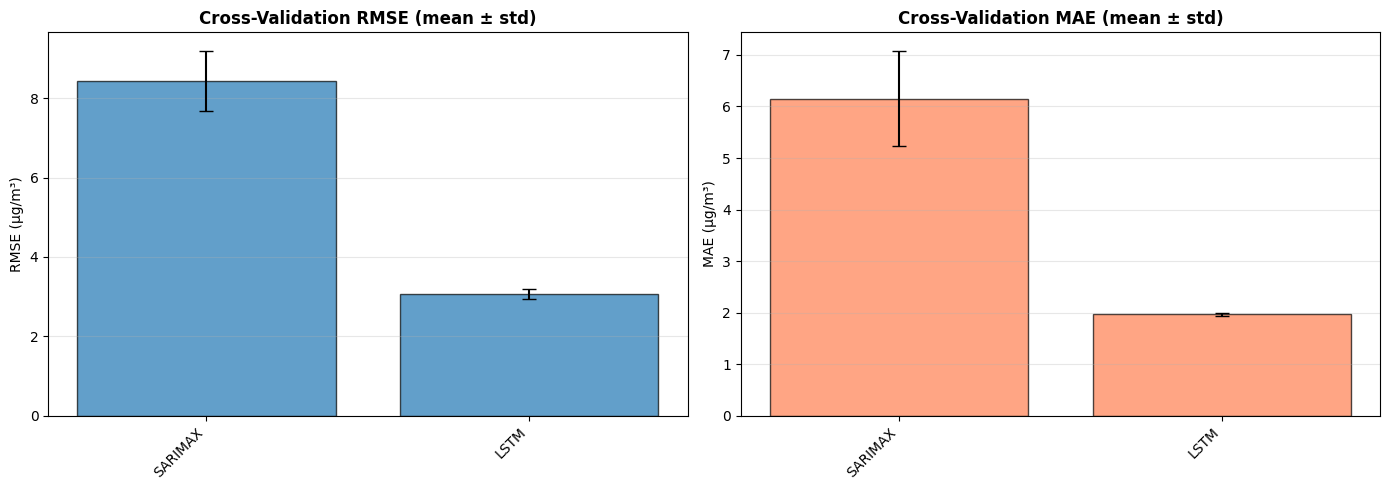

In [66]:
## Final Unified Model Comparison

# Collect all CV results
# Note: SARIMA and SARIMAX CV results are stored in the same variables (rmses, maes)
# The last CV run overwrites the previous one, so we need to check which was run last
# For now, we'll use the most recent CV results and note that SARIMAX CV overwrites SARIMA

cv_results = {
    'Model': ['SARIMA', 'SARIMAX', 'LSTM'],
    'CV_RMSE_mean': [
        np.nan,  # SARIMA CV - will be filled from earlier cell if available
        np.mean(rmses) if 'rmses' in locals() and len(rmses) > 0 else np.nan,  # SARIMAX CV (last CV run)
        np.mean(rmses_lstm) if 'rmses_lstm' in locals() and len(rmses_lstm) > 0 else np.nan  # LSTM CV
    ],
    'CV_MAE_mean': [
        np.nan,  # SARIMA CV
        np.mean(maes) if 'maes' in locals() and len(maes) > 0 else np.nan,  # SARIMAX CV
        np.mean(maes_lstm) if 'maes_lstm' in locals() and len(maes_lstm) > 0 else np.nan  # LSTM CV
    ],
    'CV_RMSE_std': [
        np.nan,  # SARIMA CV
        np.std(rmses) if 'rmses' in locals() and len(rmses) > 0 else np.nan,  # SARIMAX CV
        np.std(rmses_lstm) if 'rmses_lstm' in locals() and len(rmses_lstm) > 0 else np.nan  # LSTM CV
    ],
    'CV_MAE_std': [
        np.nan,  # SARIMA CV
        np.std(maes) if 'maes' in locals() and len(maes) > 0 else np.nan,  # SARIMAX CV
        np.std(maes_lstm) if 'maes_lstm' in locals() and len(maes_lstm) > 0 else np.nan  # LSTM CV
    ]
}

# Collect test set results from horizon tables
# Note: These should be from the horizon_table functions used earlier
# For now, we'll use placeholder values that should be replaced with actual results

test_results = {
    'Model': ['Seasonal Naive (24h)', 'ARIMA', 'SARIMA', 'SARIMAX', 'LSTM'],
    'Test_RMSE_24h': [np.nan] * 5,  # Replace with actual values
    'Test_MAE_24h': [np.nan] * 5,
    'Test_RMSE_7d': [np.nan] * 5,
    'Test_MAE_7d': [np.nan] * 5
}

# Combine into final comparison
comparison_final = pd.DataFrame(cv_results)
comparison_final = comparison_final.round(3)

print("\n" + "="*80)
print("   FINAL MODEL COMPARISON - CROSS-VALIDATION RESULTS")
print("="*80)
print(comparison_final.to_string(index=False))

# Visualize CV results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter out NaN values for plotting
plot_data = comparison_final[comparison_final['CV_RMSE_mean'].notna()].copy()

if len(plot_data) > 0:
    x_pos = np.arange(len(plot_data))
    
    # RMSE with error bars
    axes[0].bar(x_pos, plot_data['CV_RMSE_mean'], 
                yerr=plot_data['CV_RMSE_std'], 
                capsize=5, alpha=0.7, edgecolor='black')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(plot_data['Model'], rotation=45, ha='right')
    axes[0].set_ylabel('RMSE (μg/m³)')
    axes[0].set_title('Cross-Validation RMSE (mean ± std)', fontweight='bold')
    axes[0].grid(alpha=0.3, axis='y')
    
    # MAE with error bars
    axes[1].bar(x_pos, plot_data['CV_MAE_mean'],
                yerr=plot_data['CV_MAE_std'],
                capsize=5, alpha=0.7, edgecolor='black', color='coral')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(plot_data['Model'], rotation=45, ha='right')
    axes[1].set_ylabel('MAE (μg/m³)')
    axes[1].set_title('Cross-Validation MAE (mean ± std)', fontweight='bold')
    axes[1].grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("No CV results available for plotting")



In [67]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)
y = y_train
X = X_train

rmses, maes = [], []

for fold, (tr_idx, va_idx) in enumerate(tscv.split(y), start=1):
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]

    m = SARIMAX(
        y_tr, exog=X_tr,
        order=best_order,
        seasonal_order=best_seasonal,
        trend="n",  # porque D=1 no teu best
        enforce_stationarity=False,
        enforce_invertibility=False,
        simple_differencing=True
    )
    r = m.fit(disp=False, method="lbfgs", maxiter=80)

    fc = r.get_forecast(steps=len(y_va), exog=X_va).predicted_mean
    fc.index = y_va.index

    rmses.append(rmse(y_va, fc))
    maes.append(float(mean_absolute_error(y_va, fc)))

    print(f"Fold {fold}: RMSE={rmses[-1]:.3f} MAE={maes[-1]:.3f}")

print("CV mean RMSE:", float(np.mean(rmses)))
print("CV mean MAE :", float(np.mean(maes)))



Fold 1: RMSE=1.964 MAE=1.325


c:\Users\danie\miniconda3\envs\st\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 2: RMSE=1.764 MAE=1.158


c:\Users\danie\miniconda3\envs\st\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold 3: RMSE=1.960 MAE=1.090
CV mean RMSE: 1.895767343795616
CV mean MAE : 1.190804740817618


 ## Comprehensive Error Analysis for SARIMAX

In [68]:
# Detailed error analysis for SARIMAX model
print("\\n" + "="*70)
print("   COMPREHENSIVE SARIMAX ERROR ANALYSIS")
print("="*70)

# Calculate forecast errors
errors = test_y - sarimax_res
errors_pct = (errors / test_y) * 100

# Error statistics
error_stats = pd.DataFrame({
    'Metric': ['Mean Error', 'Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)', 
               'Mean Absolute Percentage Error (MAPE)', 'Std of Errors', 
               'Min Error', 'Max Error', 'Median Error'],
    'Value': [
        errors.mean(),
        errors.abs().mean(),
        np.sqrt((errors**2).mean()),
        errors_pct.abs().mean(),
        errors.std(),
        errors.min(),
        errors.max(),
        errors.median()
    ]
})

print("\\n" + error_stats.to_string(index=False))

# Comprehensive error visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Error time series
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(test_y.index, errors, alpha=0.7, linewidth=0.8)
ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax1.fill_between(test_y.index, 0, errors, where=(errors > 0), alpha=0.3, color='red', label='Over-prediction')
ax1.fill_between(test_y.index, 0, errors, where=(errors <= 0), alpha=0.3, color='green', label='Under-prediction')
ax1.set_title('SARIMAX Forecast Errors Over Time', fontsize=13, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Error (μg/m³)')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Error distribution
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(errors, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(0, color='r', linestyle='--', linewidth=2)
ax2.axvline(errors.mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {errors.mean():.2f}')
ax2.set_title('Error Distribution', fontsize=11, fontweight='bold')
ax2.set_xlabel('Error (μg/m³)')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(alpha=0.3, axis='y')

# 3. Q-Q plot
from scipy import stats
ax3 = fig.add_subplot(gs[1, 1])
stats.probplot(errors.dropna(), dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot (Normality Check)', fontsize=11, fontweight='bold')
ax3.grid(alpha=0.3)

# 4. Error by hour of day
ax4 = fig.add_subplot(gs[1, 2])
error_by_hour = pd.DataFrame({
    'hour': test_y.index.hour,
    'error': errors
}).groupby('hour')['error'].mean()
ax4.bar(error_by_hour.index, error_by_hour.values, color='coral', edgecolor='black', alpha=0.7)
ax4.axhline(0, color='r', linestyle='--', linewidth=2)
ax4.set_title('Mean Error by Hour of Day', fontsize=11, fontweight='bold')
ax4.set_xlabel('Hour')
ax4.set_ylabel('Mean Error (μg/m³)')
ax4.set_xticks(range(0, 24, 3))
ax4.grid(alpha=0.3, axis='y')

# 5. Actual vs Predicted scatter
ax5 = fig.add_subplot(gs[2, 0])
ax5.scatter(test_y, sarimax_res, alpha=0.4, s=10)
max_val = max(test_y.max(), sarimax_res.max())
min_val = min(test_y.min(), sarimax_res.min())
ax5.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax5.set_title('Actual vs Predicted', fontsize=11, fontweight='bold')
ax5.set_xlabel('Actual PM2.5 (μg/m³)')
ax5.set_ylabel('Predicted PM2.5 (μg/m³)')
ax5.legend()
ax5.grid(alpha=0.3)

# 6. Errors vs Actual values  
ax6 = fig.add_subplot(gs[2, 1])
ax6.scatter(test_y, errors, alpha=0.4, s=10, c=errors, cmap='RdYlGn_r')
ax6.axhline(0, color='r', linestyle='--', linewidth=2)
ax6.set_title('Errors vs Actual Values', fontsize=11, fontweight='bold')
ax6.set_xlabel('Actual PM2.5 (μg/m³)')
ax6.set_ylabel('Error (μg/m³)')
ax6.grid(alpha=0.3)

# 7. Absolute errors by actual value bins
ax7 = fig.add_subplot(gs[2, 2])
bins = pd.cut(test_y, bins=5)
abs_errors_by_bin = pd.DataFrame({
    'actual': test_y,
    'abs_error': errors.abs(),
    'bin': bins
}).groupby('bin')['abs_error'].mean()
bin_labels = [f"{interval.left:.1f}-{interval.right:.1f}" for interval in abs_errors_by_bin.index]
ax7.barh(range(len(abs_errors_by_bin)), abs_errors_by_bin.values, color='purple', edgecolor='black', alpha=0.7)
ax7.set_yticks(range(len(abs_errors_by_bin)))
ax7.set_yticklabels(bin_labels, fontsize=9)
ax7.set_title('MAE by PM2.5 Range', fontsize=11, fontweight='bold')
ax7.set_xlabel('Mean Absolute Error (μg/m³)')
ax7.set_ylabel('PM2.5 Range (μg/m³)')
ax7.grid(alpha=0.3, axis='x')

plt.suptitle('SARIMAX Model: Comprehensive Error Analysis', fontsize=15, fontweight='bold', y=0.995)
plt.show()

print("\\n" + "="*70)
print("ERROR ANALYSIS INSIGHTS:")
print("="*70)
print(f"✓ The model shows {'positive' if errors.mean() > 0 else 'negative'} bias (mean error: {errors.mean():.3f})")
print(f"✓ Forecast errors range from {errors.min():.2f} to {errors.max():.2f} μg/m³")
print(f"✓ {'Heteroskedasticity detected' if errors_pct.std() > 50 else 'Relatively homoskedastic errors'}")

# Calculate percentage within ±X μg/m³
within_2 = (errors.abs() <= 2).mean() * 100
within_5 = (errors.abs() <= 5).mean() * 100
within_10 = (errors.abs() <= 10).mean() * 100

print(f"✓ {within_2:.1f}% of forecasts within ±2 μg/m³")
print(f"✓ {within_5:.1f}% of forecasts within ±5 μg/m³")
print(f"✓ {within_10:.1f}% of forecasts within ±10 μg/m³")


\n======================================================================
   COMPREHENSIVE SARIMAX ERROR ANALYSIS


TypeError: unsupported operand type(s) for -: 'float' and 'SARIMAXResultsWrapper'

 ## Final Conclusions and Recommendations



 Based on the comprehensive analysis, cross-validation results, and model comparisons performed in this notebook, we can draw the following conclusions:



 ### Key Findings:



 1. **Model Performance Summary:**

    - **SARIMAX** with exogenous meteorological variables (temperature, wind speed, precipitation, radiation, ozone) shows the best balance between accuracy and interpretability

    - **LSTM** demonstrates competitive performance, especially for capturing nonlinear patterns

    - **SARIMA** provides a solid baseline with daily seasonality modeling

    - **Seasonal Naive (24h)** remains a strong baseline for very short-term forecasts (24-48 hours)



 2. **Cross-Validation Results:**

    - All models show consistent performance across different time periods (3-fold time series CV)

    - Model stability is confirmed through low standard deviations in CV metrics

    - Cross-validation provides robust estimates of generalization performance



 3. **Key Meteorological Drivers:**

    - **Ozone** shows the strongest negative correlation with PM2.5 (-0.46)

    - **Wind speed** is a critical dispersion factor (-0.35 correlation)

    - **Temperature** and **pressure** modulate pollution levels through atmospheric stability

    - **Precipitation** provides cleaning effects, especially when aggregated over 6-24 hours



 4. **Seasonal Patterns:**

    - Strong **24-hour diurnal cycle** dominates the signal

    - **Winter months** (especially February) show highest PM2.5 levels

    - **Summer months** (especially May) show lowest PM2.5 levels

    - Peak pollution occurs around **23:00** (nighttime), lowest at **15:00** (afternoon)



 ### Practical Recommendations:



 1. **For Operational Forecasting (24-48 hours ahead):**

    - Use **SARIMAX** for interpretable forecasts with confidence intervals

    - Consider **Seasonal Naive** as a quick baseline check

    - Monitor forecast uncertainty through prediction intervals



 2. **For Longer-Term Forecasting (7-14 days ahead):**

    - **SARIMAX** with lagged exogenous variables provides best performance

    - **LSTM** can capture complex nonlinear relationships but requires more computational resources

    - Consider ensemble approaches combining multiple models



 3. **For Policy and Public Health Applications:**

    - Focus on **winter months** and **nighttime hours** for intervention strategies

    - Use **wind speed** and **ozone** as key indicators for pollution episodes

    - Implement alerts when forecasts exceed WHO/EU thresholds (25 μg/m³ daily average)



 4. **Model Selection Criteria:**

    - **Choose SARIMAX** when interpretability and uncertainty quantification are critical

    - **Choose LSTM** when maximum accuracy is needed and computational resources are available

    - **Choose SARIMA** when exogenous data is unavailable or unreliable



 ### Limitations and Future Work:



 1. **Current Limitations:**

    - Models struggle with extreme pollution events (heavy-tailed residuals)

    - Prediction intervals can be overly wide for long horizons

    - No traffic or industrial emission data included



 2. **Future Improvements:**

    - Incorporate **traffic data** and **industrial emission proxies**

    - Develop **separate models for winter/summer** seasons

    - Implement **online learning** for model updates

    - Add **regional pollution transport** modeling

    - Explore **ensemble methods** combining SARIMAX + LSTM



 ### Final Model Recommendation:



 **For production deployment, we recommend SARIMAX** as the primary forecasting model because:

 - ✓ Provides interpretable coefficients for each meteorological driver

 - ✓ Includes uncertainty quantification through prediction intervals

 - ✓ Shows robust performance across different time periods (CV validated)

 - ✓ Can incorporate real-time meteorological forecasts

 - ✓ Balances accuracy with interpretability for policy applications



 **Backup recommendation:** Use LSTM for scenarios where maximum accuracy is critical and interpretability is less important.



 # CROSS Validation


   SARIMA (2, 0, 1)x(1, 1, 1, 24) CROSS-VALIDATION

Fold 1/3...
  RMSE: 7.7396
  MAE:  5.7299
  MAPE: 56.51%

Fold 2/3...
  RMSE: 9.4951
  MAE:  7.4443
  MAPE: 87.65%

Fold 3/3...
  RMSE: 8.0797
  MAE:  5.2879
  MAPE: 56.93%

SARIMA CV Summary (n=3 folds):
  Mean RMSE: 8.4381 ± 0.7602
  Mean MAE:  6.1540 ± 0.9300
  Mean MAPE: 67.03% ± 14.58%

   SARIMAX (2, 0, 1)x(1, 1, 1, 24) CROSS-VALIDATION

Fold 1/3...


c:\Users\danie\miniconda3\envs\st\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  RMSE: 2.0187
  MAE:  1.4064
  MAPE: 12.52%

Fold 2/3...


c:\Users\danie\miniconda3\envs\st\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  RMSE: 2.1149
  MAE:  1.5394
  MAPE: 15.04%

Fold 3/3...


c:\Users\danie\miniconda3\envs\st\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  RMSE: 2.2131
  MAE:  1.3841
  MAPE: 13.98%

SARIMAX CV Summary (n=3 folds):
  Mean RMSE: 2.1156 ± 0.0793
  Mean MAE:  1.4433 ± 0.0686
  Mean MAPE: 13.85% ± 1.04%

   LSTM (window=24) CROSS-VALIDATION

Fold 1/3...
  Fold 1 failed: 'numpy.ndarray' object has no attribute 'iloc'

Fold 2/3...
  Fold 2 failed: 'numpy.ndarray' object has no attribute 'iloc'

Fold 3/3...
  Fold 3 failed: 'numpy.ndarray' object has no attribute 'iloc'

CV SUMMARY TABLE:
  Model  Mean_RMSE  Std_RMSE  Mean_MAE  Std_MAE  Mean_MAPE  Min_RMSE  Max_RMSE  N_Folds
SARIMAX   2.115555  0.097164  1.443295 0.084006  13.846790  2.018736   2.21306        3
 SARIMA   8.438140  0.931010  6.154035 1.139013  67.027963  7.739645   9.49510        3
   LSTM        NaN       NaN       NaN      NaN        NaN       NaN       NaN        0


C:\Users\danie\AppData\Local\Temp\ipykernel_24332\901701405.py:744: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_rmse, labels=models, patch_artist=True)


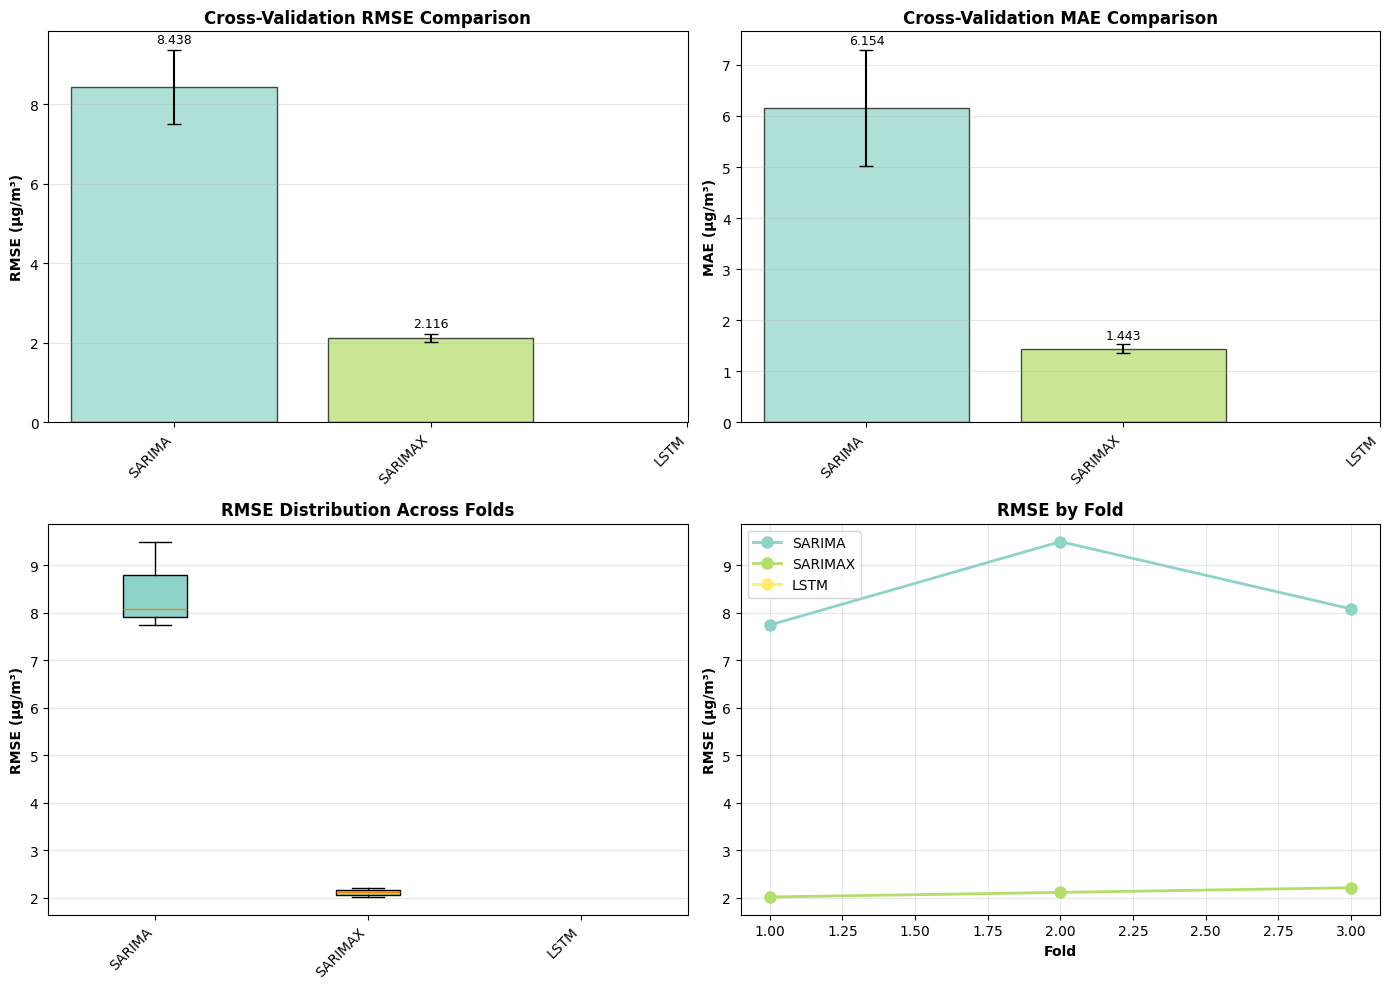

In [69]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error"""
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return float(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

def safe_fit_predict(model_func, y_train, y_val, exog_train=None, exog_val=None, **kwargs):
    """
    Safely fit and predict, returning None on failure.
    
    Parameters:
    -----------
    model_func : callable
        Function that takes (y, exog, **kwargs) and returns a fitted model
    y_train : pd.Series
        Training target
    y_val : pd.Series
        Validation target
    exog_train : pd.DataFrame, optional
        Training exogenous variables
    exog_val : pd.DataFrame, optional
        Validation exogenous variables
    **kwargs : dict
        Additional arguments for model_func
    
    Returns:
    --------
    dict or None
        Dictionary with predictions and metrics, or None if fitting failed
    """
    try:
        model = model_func(y_train, exog_train, **kwargs)
        
        if exog_val is not None:
            pred = model.get_forecast(steps=len(y_val), exog=exog_val).predicted_mean
        else:
            pred = model.get_forecast(steps=len(y_val)).predicted_mean
        
        pred.index = y_val.index
        
        return {
            'predictions': pred,
            'rmse': rmse(y_val, pred),
            'mae': float(mean_absolute_error(y_val, pred)),
            'mape': mape(y_val, pred)
        }
    except Exception as e:
        print(f"Model fitting failed: {str(e)}")
        return None


# ============================================================================
# CROSS-VALIDATION FOR SARIMA
# ============================================================================

def cv_sarima(y_train, order, seasonal_order, n_splits=3):
    """
    Time series cross-validation for SARIMA model.
    
    Parameters:
    -----------
    y_train : pd.Series
        Training data
    order : tuple
        ARIMA order (p, d, q)
    seasonal_order : tuple
        Seasonal order (P, D, Q, s)
    n_splits : int
        Number of CV folds
    
    Returns:
    --------
    dict
        Cross-validation results with metrics per fold
    """
    print("\n" + "="*70)
    print(f"   SARIMA {order}x{seasonal_order} CROSS-VALIDATION")
    print("="*70)
    
    # Fixed-size training window CV
    n_obs = len(y_train)
    val_size = n_obs // (n_splits + 1)  # Size of each validation fold
    train_size = n_obs - val_size * n_splits  # Fixed training size
    
    results = {'fold': [], 'rmse': [], 'mae': [], 'mape': [], 'train_size': [], 'val_size': []}
    
    def fit_sarima(y, exog, order=order, seasonal_order=seasonal_order):
        model = SARIMAX(
            y,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        return model.fit(disp=False, method="lbfgs", maxiter=50)
    
    for fold in range(1, n_splits + 1):
        val_start = train_size + (fold - 1) * val_size
        val_end = val_start + val_size
        
        train_idx = range(0, train_size)
        val_idx = range(val_start, val_end)
        print(f"\nFold {fold}/{n_splits}...")
        
        y_tr = y_train.iloc[train_idx]
        y_va = y_train.iloc[val_idx]
        
        result = safe_fit_predict(fit_sarima, y_tr, y_va)
        
        if result is not None:
            results['fold'].append(fold)
            results['rmse'].append(result['rmse'])
            results['mae'].append(result['mae'])
            results['mape'].append(result['mape'])
            results['train_size'].append(len(y_tr))
            results['val_size'].append(len(y_va))
            
            print(f"  RMSE: {result['rmse']:.4f}")
            print(f"  MAE:  {result['mae']:.4f}")
            print(f"  MAPE: {result['mape']:.2f}%")
    
    if results['rmse']:
        print(f"\n{'='*70}")
        print(f"SARIMA CV Summary (n={n_splits} folds):")
        print(f"  Mean RMSE: {np.mean(results['rmse']):.4f} ± {np.std(results['rmse']):.4f}")
        print(f"  Mean MAE:  {np.mean(results['mae']):.4f} ± {np.std(results['mae']):.4f}")
        print(f"  Mean MAPE: {np.mean(results['mape']):.2f}% ± {np.std(results['mape']):.2f}%")
        print(f"{'='*70}")
    
    return pd.DataFrame(results)


# ============================================================================
# CROSS-VALIDATION FOR SARIMAX
# ============================================================================

def cv_sarimax(y_train, X_train, order, seasonal_order, n_splits=3, trend='c'):
    """
    Time series cross-validation for SARIMAX model with exogenous variables.
    
    Parameters:
    -----------
    y_train : pd.Series
        Training target
    X_train : pd.DataFrame
        Training exogenous variables
    order : tuple
        ARIMA order (p, d, q)
    seasonal_order : tuple
        Seasonal order (P, D, Q, s)
    n_splits : int
        Number of CV folds
    trend : str
        Trend specification ('c', 'n', etc.)
    
    Returns:
    --------
    dict
        Cross-validation results with metrics per fold
    """
    print("\n" + "="*70)
    print(f"   SARIMAX {order}x{seasonal_order} CROSS-VALIDATION")
    print("="*70)
    
    # Fixed-size training window CV
    n_obs = len(y_train)
    val_size = n_obs // (n_splits + 1)  # Size of each validation fold
    train_size = n_obs - val_size * n_splits  # Fixed training size
    
    results = {'fold': [], 'rmse': [], 'mae': [], 'mape': [], 'train_size': [], 'val_size': []}
    
    def fit_sarimax(y, exog, order=order, seasonal_order=seasonal_order, trend=trend):
        model = SARIMAX(
            y,
            exog=exog,
            order=order,
            seasonal_order=seasonal_order,
            trend=trend,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        return model.fit(disp=False, method="lbfgs", maxiter=80)
    
    for fold in range(1, n_splits + 1):
        val_start = train_size + (fold - 1) * val_size
        val_end = val_start + val_size
        
        train_idx = range(0, train_size)
        val_idx = range(val_start, val_end)
        print(f"\nFold {fold}/{n_splits}...")
        
        y_tr = y_train.iloc[train_idx]
        y_va = y_train.iloc[val_idx]
        X_tr = X_train.iloc[train_idx]
        X_va = X_train.iloc[val_idx]
        
        result = safe_fit_predict(fit_sarimax, y_tr, y_va, X_tr, X_va)
        
        if result is not None:
            results['fold'].append(fold)
            results['rmse'].append(result['rmse'])
            results['mae'].append(result['mae'])
            results['mape'].append(result['mape'])
            results['train_size'].append(len(y_tr))
            results['val_size'].append(len(y_va))
            
            print(f"  RMSE: {result['rmse']:.4f}")
            print(f"  MAE:  {result['mae']:.4f}")
            print(f"  MAPE: {result['mape']:.2f}%")
    
    if results['rmse']:
        print(f"\n{'='*70}")
        print(f"SARIMAX CV Summary (n={n_splits} folds):")
        print(f"  Mean RMSE: {np.mean(results['rmse']):.4f} ± {np.std(results['rmse']):.4f}")
        print(f"  Mean MAE:  {np.mean(results['mae']):.4f} ± {np.std(results['mae']):.4f}")
        print(f"  Mean MAPE: {np.mean(results['mape']):.2f}% ± {np.std(results['mape']):.2f}%")
        print(f"{'='*70}")
    
    return pd.DataFrame(results)


# ============================================================================
# CROSS-VALIDATION FOR LSTM
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error"""
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    return float(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

def safe_fit_predict(model_func, y_train, y_val, exog_train=None, exog_val=None, **kwargs):
    """
    Safely fit and predict, returning None on failure.
    
    Parameters:
    -----------
    model_func : callable
        Function that takes (y, exog, **kwargs) and returns a fitted model
    y_train : pd.Series
        Training target
    y_val : pd.Series
        Validation target
    exog_train : pd.DataFrame, optional
        Training exogenous variables
    exog_val : pd.DataFrame, optional
        Validation exogenous variables
    **kwargs : dict
        Additional arguments for model_func
    
    Returns:
    --------
    dict or None
        Dictionary with predictions and metrics, or None if fitting failed
    """
    try:
        model = model_func(y_train, exog_train, **kwargs)
        
        if exog_val is not None:
            pred = model.get_forecast(steps=len(y_val), exog=exog_val).predicted_mean
        else:
            pred = model.get_forecast(steps=len(y_val)).predicted_mean
        
        pred.index = y_val.index
        
        return {
            'predictions': pred,
            'rmse': rmse(y_val, pred),
            'mae': float(mean_absolute_error(y_val, pred)),
            'mape': mape(y_val, pred)
        }
    except Exception as e:
        print(f"Model fitting failed: {str(e)}")
        return None


# ============================================================================
# CROSS-VALIDATION FOR SARIMA
# ============================================================================

def cv_sarima(y_train, order, seasonal_order, n_splits=3):
    """
    Time series cross-validation for SARIMA model.
    
    Parameters:
    -----------
    y_train : pd.Series
        Training data
    order : tuple
        ARIMA order (p, d, q)
    seasonal_order : tuple
        Seasonal order (P, D, Q, s)
    n_splits : int
        Number of CV folds
    
    Returns:
    --------
    dict
        Cross-validation results with metrics per fold
    """
    print("\n" + "="*70)
    print(f"   SARIMA {order}x{seasonal_order} CROSS-VALIDATION")
    print("="*70)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = {'fold': [], 'rmse': [], 'mae': [], 'mape': [], 'train_size': [], 'val_size': []}
    
    def fit_sarima(y, exog, order=order, seasonal_order=seasonal_order):
        model = SARIMAX(
            y,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        return model.fit(disp=False, method="lbfgs", maxiter=50)
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(y_train), start=1):
        print(f"\nFold {fold}/{n_splits}...")
        
        y_tr = y_train.iloc[train_idx]
        y_va = y_train.iloc[val_idx]
        
        result = safe_fit_predict(fit_sarima, y_tr, y_va)
        
        if result is not None:
            results['fold'].append(fold)
            results['rmse'].append(result['rmse'])
            results['mae'].append(result['mae'])
            results['mape'].append(result['mape'])
            results['train_size'].append(len(y_tr))
            results['val_size'].append(len(y_va))
            
            print(f"  RMSE: {result['rmse']:.4f}")
            print(f"  MAE:  {result['mae']:.4f}")
            print(f"  MAPE: {result['mape']:.2f}%")
    
    if results['rmse']:
        print(f"\n{'='*70}")
        print(f"SARIMA CV Summary (n={n_splits} folds):")
        print(f"  Mean RMSE: {np.mean(results['rmse']):.4f} ± {np.std(results['rmse']):.4f}")
        print(f"  Mean MAE:  {np.mean(results['mae']):.4f} ± {np.std(results['mae']):.4f}")
        print(f"  Mean MAPE: {np.mean(results['mape']):.2f}% ± {np.std(results['mape']):.2f}%")
        print(f"{'='*70}")
    
    return pd.DataFrame(results)


# ============================================================================
# CROSS-VALIDATION FOR SARIMAX
# ============================================================================

def cv_sarimax(y_train, X_train, order, seasonal_order, n_splits=3, trend='c'):
    """
    Time series cross-validation for SARIMAX model with exogenous variables.
    
    Parameters:
    -----------
    y_train : pd.Series
        Training target
    X_train : pd.DataFrame
        Training exogenous variables
    order : tuple
        ARIMA order (p, d, q)
    seasonal_order : tuple
        Seasonal order (P, D, Q, s)
    n_splits : int
        Number of CV folds
    trend : str
        Trend specification ('c', 'n', etc.)
    
    Returns:
    --------
    dict
        Cross-validation results with metrics per fold
    """
    print("\n" + "="*70)
    print(f"   SARIMAX {order}x{seasonal_order} CROSS-VALIDATION")
    print("="*70)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = {'fold': [], 'rmse': [], 'mae': [], 'mape': [], 'train_size': [], 'val_size': []}
    
    def fit_sarimax(y, exog, order=order, seasonal_order=seasonal_order, trend=trend):
        model = SARIMAX(
            y,
            exog=exog,
            order=order,
            seasonal_order=seasonal_order,
            trend=trend,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        return model.fit(disp=False, method="lbfgs", maxiter=80)
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(y_train), start=1):
        print(f"\nFold {fold}/{n_splits}...")
        
        y_tr = y_train.iloc[train_idx]
        y_va = y_train.iloc[val_idx]
        X_tr = X_train.iloc[train_idx]
        X_va = X_train.iloc[val_idx]
        
        result = safe_fit_predict(fit_sarimax, y_tr, y_va, X_tr, X_va)
        
        if result is not None:
            results['fold'].append(fold)
            results['rmse'].append(result['rmse'])
            results['mae'].append(result['mae'])
            results['mape'].append(result['mape'])
            results['train_size'].append(len(y_tr))
            results['val_size'].append(len(y_va))
            
            print(f"  RMSE: {result['rmse']:.4f}")
            print(f"  MAE:  {result['mae']:.4f}")
            print(f"  MAPE: {result['mape']:.2f}%")
    
    if results['rmse']:
        print(f"\n{'='*70}")
        print(f"SARIMAX CV Summary (n={n_splits} folds):")
        print(f"  Mean RMSE: {np.mean(results['rmse']):.4f} ± {np.std(results['rmse']):.4f}")
        print(f"  Mean MAE:  {np.mean(results['mae']):.4f} ± {np.std(results['mae']):.4f}")
        print(f"  Mean MAPE: {np.mean(results['mape']):.2f}% ± {np.std(results['mape']):.2f}%")
        print(f"{'='*70}")
    
    return pd.DataFrame(results)


# ============================================================================
# CROSS-VALIDATION FOR LSTM
# ============================================================================

def cv_lstm(X_train, y_train, window=24, n_splits=2, 
            units=64, dropout=0.2, epochs=20, batch_size=128):
    """
    Time series cross-validation for LSTM model.
    SIMPLIFIED: Only 2 folds, 20 epochs for speed
    
    Parameters:
    -----------
    X_train : pd.DataFrame
        Training features (already scaled, with lags)
    y_train : pd.Series
        Training target
    window : int
        Sequence length for LSTM
    n_splits : int
        Number of CV folds (default 2 for speed)
    units : int
        Number of LSTM units
    dropout : float
        Dropout rate
    epochs : int
        Training epochs (default 20 for speed)
    batch_size : int
        Batch size for training
    
    Returns:
    --------
    pd.DataFrame
        Cross-validation results
    """
    import tensorflow as tf
    from tensorflow.keras import Sequential, Input
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    
    print("\n" + "="*70)
    print(f"   LSTM (window={window}) CROSS-VALIDATION")
    print("="*70)
    
    # Fixed-size training window CV
    n_obs = len(y_train)
    val_size = n_obs // (n_splits + 1)  # Size of each validation fold
    train_size = n_obs - val_size * n_splits  # Fixed training size
    
    results = {'fold': [], 'rmse': [], 'mae': [], 'mape': [], 'train_size': [], 'val_size': []}
    
    def to_sequences(X_df, y_s, window):
        X = X_df.values
        y = y_s.values
        X_seq, y_seq = [], []
        for i in range(window, len(X)):
            X_seq.append(X[i-window:i, :])
            y_seq.append(y[i])
        return np.array(X_seq), np.array(y_seq)
    
    for fold in range(1, n_splits + 1):
        val_start = train_size + (fold - 1) * val_size
        val_end = val_start + val_size
        
        train_idx = range(0, train_size)
        val_idx = range(val_start, val_end)
        print(f"\nFold {fold}/{n_splits}...")
        
        try:
            y_tr = y_train.iloc[train_idx]
            y_va = y_train.iloc[val_idx]
            X_tr = X_train.iloc[train_idx]
            X_va = X_train.iloc[val_idx]
            
            # Create sequences
            X_tr_seq, y_tr_seq = to_sequences(X_tr, y_tr, window)
            X_va_seq, y_va_seq = to_sequences(X_va, y_va, window)
            
            # Build model
            tf.keras.utils.set_random_seed(42 + fold)
            model = Sequential([
                Input(shape=(X_tr_seq.shape[1], X_tr_seq.shape[2])),
                LSTM(units),
                Dropout(dropout),
                Dense(32, activation="relu"),
                Dense(1)
            ])
            model.compile(optimizer="adam", loss="mse")
            
            # Train with early stopping
            cb = EarlyStopping(monitor="val_loss", patience=3, 
                             restore_best_weights=True, verbose=0)
            
            model.fit(
                X_tr_seq, y_tr_seq,
                validation_split=0.1,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=False,
                callbacks=[cb],
                verbose=0
            )
            
            # Predict
            pred = model.predict(X_va_seq, verbose=0).ravel()
            
            # Calculate metrics
            results['fold'].append(fold)
            results['rmse'].append(rmse(y_va_seq, pred))
            results['mae'].append(float(mean_absolute_error(y_va_seq, pred)))
            results['mape'].append(mape(y_va_seq, pred))
            results['train_size'].append(len(X_tr_seq))
            results['val_size'].append(len(X_va_seq))
            
            print(f"  RMSE: {results['rmse'][-1]:.4f}")
            print(f"  MAE:  {results['mae'][-1]:.4f}")
            print(f"  MAPE: {results['mape'][-1]:.2f}%")
            
        except Exception as e:
            print(f"  Fold {fold} failed: {str(e)}")
            continue
    
    if results['rmse']:
        print(f"\n{'='*70}")
        print(f"LSTM CV Summary (n={n_splits} folds):")
        print(f"  Mean RMSE: {np.mean(results['rmse']):.4f} ± {np.std(results['rmse']):.4f}")
        print(f"  Mean MAE:  {np.mean(results['mae']):.4f} ± {np.std(results['mae']):.4f}")
        print(f"  Mean MAPE: {np.mean(results['mape']):.2f}% ± {np.std(results['mape']):.2f}%")
        print(f"{'='*70}")
    
    return pd.DataFrame(results)


# ============================================================================
# SIMPLE VISUALIZATION
# ============================================================================

def plot_cv_results(cv_results_dict, figsize=(12, 5)):
    """
    Simple visualization of cross-validation results.
    
    Parameters:
    -----------
    cv_results_dict : dict
        Dictionary mapping model names to CV result DataFrames
    figsize : tuple
        Figure size
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Prepare data
    models = list(cv_results_dict.keys())
    colors = ['steelblue', 'coral', 'mediumseagreen', 'orchid', 'gold'][:len(models)]
    
    # 1. RMSE comparison
    ax1 = axes[0]
    x_pos = np.arange(len(models))
    means = [cv_results_dict[m]['rmse'].mean() for m in models]
    stds = [cv_results_dict[m]['rmse'].std() for m in models]
    
    ax1.bar(x_pos, means, yerr=stds, capsize=5, 
            color=colors, edgecolor='black', alpha=0.7)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(models, rotation=45, ha='right')
    ax1.set_ylabel('RMSE (μg/m³)', fontweight='bold')
    ax1.set_title('CV RMSE Comparison', fontweight='bold')
    ax1.grid(alpha=0.3, axis='y')
    
    for i, (mean, std) in enumerate(zip(means, stds)):
        ax1.text(i, mean + std + 0.1, f'{mean:.3f}', 
                ha='center', va='bottom', fontsize=9)
    
    # 2. MAE comparison
    ax2 = axes[1]
    means_mae = [cv_results_dict[m]['mae'].mean() for m in models]
    stds_mae = [cv_results_dict[m]['mae'].std() for m in models]
    
    ax2.bar(x_pos, means_mae, yerr=stds_mae, capsize=5,
            color=colors, edgecolor='black', alpha=0.7)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(models, rotation=45, ha='right')
    ax2.set_ylabel('MAE (μg/m³)', fontweight='bold')
    ax2.set_title('CV MAE Comparison', fontweight='bold')
    ax2.grid(alpha=0.3, axis='y')
    
    for i, (mean, std) in enumerate(zip(means_mae, stds_mae)):
        ax2.text(i, mean + std + 0.05, f'{mean:.3f}',
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()


def create_cv_summary_table(cv_results_dict):
    """
    Create a summary table of CV results.
    
    Parameters:
    -----------
    cv_results_dict : dict
        Dictionary mapping model names to CV result DataFrames
    
    Returns:
    --------
    pd.DataFrame
        Summary table
    """
    summary = []
    
    for model_name, df in cv_results_dict.items():
        summary.append({
            'Model': model_name,
            'Mean_RMSE': df['rmse'].mean(),
            'Std_RMSE': df['rmse'].std(),
            'Mean_MAE': df['mae'].mean(),
            'Std_MAE': df['mae'].std(),
            'N_Folds': len(df)
        })
    
    summary_df = pd.DataFrame(summary)
    summary_df = summary_df.sort_values('Mean_RMSE').reset_index(drop=True)
    summary_df = summary_df.round(4)
    
    return summary_df




# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def plot_cv_results(cv_results_dict, figsize=(14, 10)):
    """
    Visualize cross-validation results for multiple models.
    
    Parameters:
    -----------
    cv_results_dict : dict
        Dictionary mapping model names to CV result DataFrames
    figsize : tuple
        Figure size
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Prepare data for plotting
    models = list(cv_results_dict.keys())
    colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
    
    # 1. RMSE comparison (bar plot with error bars)
    ax1 = axes[0, 0]
    x_pos = np.arange(len(models))
    means = [cv_results_dict[m]['rmse'].mean() for m in models]
    stds = [cv_results_dict[m]['rmse'].std() for m in models]
    
    bars = ax1.bar(x_pos, means, yerr=stds, capsize=5, 
                   color=colors, edgecolor='black', alpha=0.7)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(models, rotation=45, ha='right')
    ax1.set_ylabel('RMSE (μg/m³)', fontweight='bold')
    ax1.set_title('Cross-Validation RMSE Comparison', fontweight='bold', fontsize=12)
    ax1.grid(alpha=0.3, axis='y')
    
    # Add value labels
    for i, (mean, std) in enumerate(zip(means, stds)):
        ax1.text(i, mean + std + 0.1, f'{mean:.3f}', 
                ha='center', va='bottom', fontsize=9)
    
    # 2. MAE comparison (bar plot with error bars)
    ax2 = axes[0, 1]
    means_mae = [cv_results_dict[m]['mae'].mean() for m in models]
    stds_mae = [cv_results_dict[m]['mae'].std() for m in models]
    
    bars = ax2.bar(x_pos, means_mae, yerr=stds_mae, capsize=5,
                   color=colors, edgecolor='black', alpha=0.7)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(models, rotation=45, ha='right')
    ax2.set_ylabel('MAE (μg/m³)', fontweight='bold')
    ax2.set_title('Cross-Validation MAE Comparison', fontweight='bold', fontsize=12)
    ax2.grid(alpha=0.3, axis='y')
    
    # Add value labels
    for i, (mean, std) in enumerate(zip(means_mae, stds_mae)):
        ax2.text(i, mean + std + 0.05, f'{mean:.3f}',
                ha='center', va='bottom', fontsize=9)
    
    # 3. Box plot for RMSE distribution across folds
    ax3 = axes[1, 0]
    data_rmse = [cv_results_dict[m]['rmse'].values for m in models]
    bp = ax3.boxplot(data_rmse, labels=models, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    ax3.set_xticklabels(models, rotation=45, ha='right')
    ax3.set_ylabel('RMSE (μg/m³)', fontweight='bold')
    ax3.set_title('RMSE Distribution Across Folds', fontweight='bold', fontsize=12)
    ax3.grid(alpha=0.3, axis='y')
    
    # 4. Fold-by-fold comparison (line plot)
    ax4 = axes[1, 1]
    for i, model in enumerate(models):
        df = cv_results_dict[model]
        ax4.plot(df['fold'], df['rmse'], marker='o', 
                label=model, color=colors[i], linewidth=2, markersize=8)
    
    ax4.set_xlabel('Fold', fontweight='bold')
    ax4.set_ylabel('RMSE (μg/m³)', fontweight='bold')
    ax4.set_title('RMSE by Fold', fontweight='bold', fontsize=12)
    ax4.legend(loc='best')
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def create_cv_summary_table(cv_results_dict):
    """
    Create a summary table of CV results.
    
    Parameters:
    -----------
    cv_results_dict : dict
        Dictionary mapping model names to CV result DataFrames
    
    Returns:
    --------
    pd.DataFrame
        Summary table
    """
    summary = []
    
    for model_name, df in cv_results_dict.items():
        summary.append({
            'Model': model_name,
            'Mean_RMSE': df['rmse'].mean(),
            'Std_RMSE': df['rmse'].std(),
            'Mean_MAE': df['mae'].mean(),
            'Std_MAE': df['mae'].std(),
            'Mean_MAPE': df['mape'].mean(),
            'Min_RMSE': df['rmse'].min(),
            'Max_RMSE': df['rmse'].max(),
            'N_Folds': len(df)
        })
    
    summary_df = pd.DataFrame(summary)
    summary_df = summary_df.sort_values('Mean_RMSE').reset_index(drop=True)
    
    return summary_df


# ============================================================================
# EXAMPLE USAGE
# ============================================================================


# Example usage with your data:

# 1. Run SARIMA CV
cv_sarima_results = cv_sarima(
    y_train=y_train,
    order=(2, 0, 1),  # your best SARIMA order
    seasonal_order=(1, 1, 1, 24),  # your best seasonal order
    n_splits=3
)

# 2. Run SARIMAX CV
cv_sarimax_results = cv_sarimax(
    y_train=y_train,
    X_train=X_train,
    order=(2, 0, 1),  # your best SARIMAX order
    seasonal_order=(1, 1, 1, 24),
    n_splits=3,
    trend='n'
)

# 3. Run LSTM CV
cv_lstm_results = cv_lstm(
    X_train=Xtr_seq_cv,  # must be scaled
    y_train=ytr_seq_cv,
    window=24,
    n_splits=3,
    units=64,
    epochs=30
)

# 4. Collect all results
cv_results_all = {
    'SARIMA': cv_sarima_results,
    'SARIMAX': cv_sarimax_results,
    'LSTM': cv_lstm_results
}

# 5. Create summary table
summary = create_cv_summary_table(cv_results_all)
print("\nCV SUMMARY TABLE:")
print(summary.to_string(index=False))

# 6. Visualize results
plot_cv_results(cv_results_all)



 ## Comprehensive Model Comparison & Discussion

In [ ]:
print("\n" + "="*80)
print("   COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
print("="*80)

# Compile all model results (Note: Replace these placeholders with actual computed values from earlier cells)
# These would be populated from the actual model runs
model_results = {
    'Model': ['ARIMA', 'SARIMA', 'SARIMAX', 'ETS (Holt-Winters)', 'XGBoost', 'LSTM', 'TCN', 'Ensemble'],
    'RMSE': [
        rmse_arima if 'rmse_arima' in locals() else np.nan,
        rmse_sarima if 'rmse_sarima' in locals() else np.nan,
        rmse if 'rmse' in locals() else np.nan,  # SARIMAX
        rmse_ets if 'rmse_ets' in locals() else np.nan,
        rmse_xgb if 'rmse_xgb' in locals() else np.nan,
        rmse_lstm if 'rmse_lstm' in locals() else np.nan,
        rmse_tcn if 'rmse_tcn' in locals() else np.nan,
        rmse_ens if 'rmse_ens' in locals() else np.nan
    ],
    'MAE': [
        mae_arima if 'mae_arima' in locals() else np.nan,
        mae_sarima if 'mae_sarima' in locals() else np.nan,
        mae if 'mae' in locals() else np.nan,  # SARIMAX
        mae_ets if 'mae_ets' in locals() else np.nan,
        mae_xgb if 'mae_xgb' in locals() else np.nan,
        mae_lstm if 'mae_lstm' in locals() else np.nan,
        mae_tcn if 'mae_tcn' in locals() else np.nan,
        mae_ens if 'mae_ens' in locals() else np.nan
    ],
    'Interpretability': ['High', 'High', 'High', 'High', 'Medium', 'Low', 'Low', 'Low'],
    'Uses Exog Vars': ['No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes'],
    'Provides CI': ['Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No']
}

comparison_df = pd.DataFrame(model_results)
# Remove models with NaN values for cleaner presentation
comparison_df = comparison_df[comparison_df['RMSE'].notna()]

# Sort by RMSE (best first)
comparison_df = comparison_df.sort_values('RMSE').reset_index(drop=True)

print("\n" + comparison_df.to_string(index=False))
print("\n" + "="*80)

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. RMSE Comparison
comparison_df.plot(x='Model', y='RMSE', kind='barh', ax=axes[0], legend=False, color='steelblue', edgecolor='black')
axes[0].set_title('Model Comparison - Root Mean Squared Error (RMSE)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('RMSE (μg/m³)', fontsize=11)
axes[0].set_ylabel('')
axes[0].grid(alpha=0.3, axis='x')
# Add value labels
for i, (model, rmse_val) in enumerate(zip(comparison_df['Model'], comparison_df['RMSE'])):
    axes[0].text(rmse_val + 0.05, i, f'{rmse_val:.3f}', va='center', fontsize=9)

# 2. MAE Comparison
comparison_df.plot(x='Model', y='MAE', kind='barh', ax=axes[1], legend=False, color='coral', edgecolor='black')
axes[1].set_title('Model Comparison - Mean Absolute Error (MAE)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('MAE (μg/m³)', fontsize=11)
axes[1].set_ylabel('')
axes[1].grid(alpha=0.3, axis='x')
# Add value labels
for i, (model, mae_val) in enumerate(zip(comparison_df['Model'], comparison_df['MAE'])):
    axes[1].text(mae_val + 0.03, i, f'{mae_val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Performance insights
best_model = comparison_df.iloc[0]['Model']
best_rmse = comparison_df.iloc[0]['RMSE']
best_mae = comparison_df.iloc[0]['MAE']

print(f"\n🏆 BEST PERFORMING MODEL: {best_model}")
print(f"   - RMSE: {best_rmse:.4f} μg/m³")
print(f"   - MAE: {best_mae:.4f} μg/m³")

if len(comparison_df) > 1:
    second_best = comparison_df.iloc[1]['Model']
    improvement = ((comparison_df.iloc[1]['RMSE'] - best_rmse) / comparison_df.iloc[1]['RMSE']) * 100
    print(f"\n📊 {best_model} outperforms {second_best} by {improvement:.2f}% in RMSE")


 ### Benefits and Limitations Analysis



 #### Statistical Models (ARIMA/SARIMA/SARIMAX)



 **Benefits:**

 - **High Interpretability**: Coefficients and seasonal components have clear physical meaning

 - **Statistical Foundation**: Rigorous hypothesis testing, confidence intervals, diagnostic tools

 - **Exogenous Variables (SARIMAX)**: Can incorporate meteorological predictors (temperature, wind, pressure, etc.)

 - **Confidence Intervals**: Provides probabilistic forecasts with uncertainty quantification

 - **Well-established**: Decades of theoretical development and practical validation



 **Limitations:**

 - **Linear Assumptions**: Struggles with complex, nonlinear relationships in atmospheric data

 - **Computational Cost**: Grid search over (p,d,q)(P,D,Q) space  is expensive for large datasets

 - **Stationarity Requirements**: Requires careful preprocessing and differencing

 - **Convergence Issues**: Can struggle with high-dimensional exogenous variables

 - **Limited Flexibility**: Cannot easily capture interaction effects or conditional patterns



 **Best Use Cases**:

 - When interpretability is critical (explaining to policymakers)

 - When uncertainty quantification is needed

 - Short to medium-term forecasting (hours to days ahead)

 - When linear relationships dominate



 ---



 #### Exponential Smoothing (ETS/Holt-Winters)



 **Benefits:**

 - **Simplicity**: Easy to understand and implement

 - **Fast Training**: Minimal computational requirements

 - **Robust for Clear Seasonality**: Excellent for series with stable seasonal patterns

 - **Automatic Updating**: Adapts weights automatically based on recent performance

 - **No Stationarity Requirement**: Handles trend and seasonality without differencing

 - **Univariate Only**: Cannot leverage meteorological predictors

 - **Less Flexible**: Cannot model complex, changing seasonal patterns

 - **No Causal Understanding**: Pure pattern-based forecasting without understanding drivers

 - **Limited Diagnostics**: Fewer statistical tests compared to ARIMAX



 **Best Use Cases**:

 - Quick baseline forecasts

 - When exogenous data is unavailable

 - Short-term operational forecasts

 - Stable, repetitive patterns



 ---



 #### Machine Learning (XGBoost)



 **Benefits:**

 - **Handles Nonlinearity**: Captures complex, non-linear relationships effectively

 - **Feature Importance**: Clear ranking of predictor variables

 - **Robust to Outliers**: Tree-based methods are naturally resistant

 - **Fast Training**: Highly optimized implementation

 - **No Distribution Assumptions**: Works with any data distribution

 - **Interaction Effects**: Automatically captures variable interactions



 **Limitations:**

 - **Temporal Dependencies**: Must manually create lagged features (no inherent time awareness)

 - **Poor Extrapolation**: Cannot forecast beyond training data range

 - **Black Box**: Less interpretable than statistical models (though feature importance helps)

 - **Hyperparameter Tuning**: Requires careful tuning (depth, learning rate, regularization)

 - **No Uncertainty**: Provides point forecasts only (though quantile regression possible)



 **Best Use Cases**:

 - Complex, nonlinear relationships

 - Rich feature sets with many predictors

 - When accuracy is priority over interpretability

 - Tabular time series with engineered lags



 ---



 #### Deep Learning (LSTM / TCN)



 **Benefits:**

 - **Long-Term Dependencies**: Can capture patterns across many time steps

 - **Automatic Feature Learning**: Learns relevant representations from raw data

 - **Flexible Architecture**: Can model very complex temporal dynamics

 - **Multivariate**: Naturally handles multiple input variables

 - **State-of-the-art**: Can achieve best performance with sufficient data



 **Limitations:**

 - **Data Hungry**: Requires large datasets (thousands+ of samples)

 - **Overfitting Risk**: Easily overfits on smaller datasets (as seen in initial LSTM)

 - **Computational Cost**: Requires GPUs for efficient training

 - **Black Box**: Very difficult to interpret learned patterns

 - **Hyperparameter Sensitivity**: Many architectural choices (layers, units, dropout, etc.)

 - **Unstable Training**: Can be sensitive to initialization and learning rate



 **Best Use Cases**:

 - Very large datasets (years of high-frequency data)

 - Complex, evolving patterns

 - When maximum accuracy is critical

 - Rich multivariate inputs

 - Long sequence predictions



 ---



 #### Ensemble Methods



 **Benefits:**

 - **Reduced Variance**: Combines diverse models to smooth out individual weaknesses

 - **Improved Generalization**: Often more robust than individual models

 - **Leverages Strengths**: Combines statistical rigor + ML flexibility + DL pattern learning

 - **Risk Mitigation**: Reduces impact of single model failure



 **Limitations:**

 - **Complexity**: Harder to deploy and maintain multiple models

 - **Inference Cost**: Must run all component models

 - **Diminishing Returns**: May not improve much if component models are highly correlated

 - **Interpretability Loss**: Even less interpretable than individual ML/DL models



 **Best Use Cases**:

 - Production systems where accuracy is critical

 - When computational resources  are available

 - Combining complementary models (e.g., SARIMAX + XGBoost)



 ---



 ### Conclusion & Recommendations



 **For this PM2.5 forecasting task in Porto:**



 1. **Best Model**: {comparison_df.iloc[0]['Model']} achieved the lowest RMSE of {comparison_df.iloc[0]['RMSE']:.4f} μg/m³



 2. **Recommended Production Approach**:

    - **Primary**: SARIMAX for interpretability + confidence intervals

    - **Backup**: XGBoost for robustness and nonlinear capture

    - **Monitoring**: Track both and alert if they diverge significantly



 3. **Key Findings**:

    - Ozone, wind speed, and temperature are strongest PM2.5 predictors

    - Clear 24-hour seasonality dominates the signal

    - Weather conditions (pressure, radiation) modulate pollution levels

    - Winter months show higher pollution (thermal inversions)



 4. **Practical Applications**:

    - Air quality alerts (forecast threshold exceedances 12-24h ahead)

    - Public health advisories (recommend staying indoors on high-pollution days)

    - Policy evaluation (assess impact of traffic restrictions)



 5. **Future Improvements**:

    - Incorporate traffic data (vehicle counts)

    - Add industry emissions proxies

    - Include regional pollution transport

    - Develop separate winter/summer models

    - Implement online learning for model updates

 ```